# This notebook is used to evaluate the total flux and luminosity of each HII regions, while taking into account the diffuse background emission and the limits of a regions using the Halpha flux profile of this region. The FWHM/2 of the Halpha profile is also defined and used has an indicator of the size of the regions (Strömgren radius).

# Starting point if the files noest exist:  see below

In [1]:
# Import Libraries
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import rc
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import scipy
from scipy import ndimage
from matplotlib.lines import Line2D
from pylab import *
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from numpy import sqrt, pi, exp, loadtxt
from lmfit import Model
from copy import deepcopy
from scipy.optimize import minimize
from lmfit.models import PseudoVoigtModel
from lmfit.models import LinearModel

In [2]:
# Read files

# Halpha maximal intensity
ahdu_list1 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.amplitude.clean.fits')
ahdu_list1.info()
aimage_data1 = ahdu_list1[0].data
ahdu_list1.close()

# Halpha FWHM in nm
fhdu_list1 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.fwhm.clean.fits')
fhdu_list1.info()
fimage_data1 = fhdu_list1[0].data
fhdu_list1.close()

# HIIR peak position
regxy = np.loadtxt('Region_xy_centroid.reg')
regx = regxy[0:,0]
regy = regxy[0:,1]

# HIIR pixels distance from the peak
dis= fits.open('NGC628_distance_grow.fits')
dis.info()
d = dis[0].data
dis.close()

# HIIR ID mask
gr= fits.open('NGC628_HIIPhot3_All_GROW.fits')
gr.info()
grow = gr[0].data
gr.close()

# Halpha flux extinction corrected
flux22 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.flux.extcor.clean.int33i.fits')
flux22.info()
flux2 = flux22[0].data
flux22.close()

print 'number of region = ',  len(regx)

Filename: NGC628_SN3_1.0.LineMaps.map.6563.amplitude.clean.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_SN3_1.0.LineMaps.map.6563.fwhm.clean.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_distance_grow.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (2048, 2064)   float32   
Filename: NGC628_HIIPhot3_All_GROW.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_SN3_1.0.LineMaps.map.6563.flux.extcor.clean.int33i.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (2048, 2064)   float64   
number of region =  4285


In [3]:
mod = PseudoVoigtModel()

In [4]:
# Halpha flux from the sinc function line profile : F = 1.20671 * Maximal intensity * FWHM [A]

flux = aimage_data1*fimage_data1*10/1.20671 
flux[(np.isfinite(flux) == False)] = 0 # remove Nan values
flux2[(np.isfinite(flux2) == False)] = 0 # remove Nan values

In [4]:
# Define the total flux (flux_tot), the limits (lim) and the background emission (med) à
# of each regions from the Halpha profile
######## Take a few minutes ########

flux_central=np.zeros(len(regx))
flux_tot=np.zeros(len(regx))
flux_tot2=np.zeros(len(regx))

n = 16
fl = np.zeros(n)
dl = np.zeros(n)
t = np.zeros(n)
tt = np.zeros(n)
t[0:16] = 500
tt[0:16] = 500
lim = np.zeros(len(regx))
med = np.zeros(len(regx))
med2 = np.zeros(len(regx))

for i in range(0,len(regx)) : 
    
    m = np.max(d[(grow == i+1)])
    dist = np.array(len(np.where(grow == i+1)[0]))
    flux_prof = np.array(len(np.where(grow == i+1)[0]))
    flux_prof2 = np.array(len(np.where(grow == i+1)[0]))

    xxyy=np.where(grow == i+1)
    dist=d[xxyy[0],xxyy[1]]
    flux_prof=flux[xxyy[0],xxyy[1]]
    flux_prof2=flux2[xxyy[0],xxyy[1]]
    maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])

    xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
    flux_prof[xx] = -10
    xx = np.where((flux_prof/maxi > 1.2) & (dist > 10)) 
    flux_prof[xx] = -10

    distt = dist[(flux_prof > -9)]
    flux_proff = np.array(len(np.where(flux_prof > -9)[0]))
    flux_proff2 = np.array(len(np.where(flux_prof > -9)[0]))

    flux_proff = flux_prof[(flux_prof > -9)]
    flux_proff2 = flux_prof2[(flux_prof > -9)]
    flux_prof=flux[xxyy[0],xxyy[1]]
    flux_prof2=flux2[xxyy[0],xxyy[1]]
    
    mm = np.max(flux_prof)
    dm = np.max(dist)
    mi = (np.median(flux_prof[(dist > dm-100)]))/mm
    if mi < 0 :
        mi = 0

    t[0:16] = 500
    tt[0:16] = 500    
    
    for j in range(0,n) :
        fl[j]= np.median(flux_prof[(dist < j*25+25)])/mm-mi
        dl[j] = j*25+12.5
        
        if j > 0 and j < 15  : 
            t[j] = fl[j-1]-fl[j]
        if j > 0 and j < 15 : 
            tt[j] = fl[j-1]-fl[j+1]

    if len(dl[(t < 0.025) & (tt < 0.15)]) == 1 :
        lim[i] = dl[(t < 0.025) & (tt < 0.15)]
    if len(dl[(t < 0.025) & (tt < 0.15)]) == 0 :
        lim[i] = m
    if len(dl[(t < 0.025) & (tt < 0.15)]) > 1 :
        lim[i] = dl[(t < 0.025) & (tt < 0.15)][0]
    if lim[i] > m :
        lim[i] = m
    if lim[i] < 100 and m > 100 :
        lim[i] = 100
    if lim[i] < 100 and m < 100 :
        lim[i] = m-5
    if lim[i] > 300 :
        lim[i] = 300
    #if dm < 250 :
    #    lim[i] = dm
    
    flux_central[i] = np.mean(flux[round(regy[i])-3:round(regy[i])+1,\
                                   round(regx[i])-3:round(regx[i])+1])
#    if not lim[i] == m :
    med[i] = np.median(flux_proff[(distt > lim[i]-5) & (distt < lim[i]+35)])
    med2[i] = np.median(flux_proff2[(distt > lim[i]-5) & (distt < lim[i]+35)])
    if med[i]/mm > 0.5 : 
         med[i] = mm*0.3
    flux_tot[i] = np.sum(flux_prof[(dist < lim[i])])\
                   -len(np.where(dist < lim[i])[0])*\
                   med[i]
    if med2[i]/mm > 0.5 : 
         med2[i] = mm*0.3
    flux_tot2[i] = np.sum(flux_prof2[(dist < lim[i])])\
                   -len(np.where(dist < lim[i])[0])*\
                   med2[i]
#    else :
#        med[i] = np.median(flux[(grow == i+1) & (d > lim[i]-25)])
#        med2[i] = np.median(flux2[(grow == i+1) & (d > lim[i]-25)])
#
#        if med[i]/mm > 0.5 : 
#            med[i] = mm*0.3
#        flux_tot[i] = np.sum(flux[(grow == i+1) & (d < lim[i])])-\
#                    len(np.where((grow == i+1) & (d < lim[i]))[1])*med[i]
#        if med2[i]/mm > 0.5 : 
#            med2[i] = mm*0.3
#        flux_tot2[i] = np.sum(flux2[(grow == i+1) & (d < lim[i])])-\
#                    len(np.where((grow == i+1) & (d < lim[i]))[1])*med2[i]
#  
# Write files
fits.writeto('NGC628_dimension_regions.fits', lim)
fits.writeto('NGC628_background.regions.fits', med)
fits.writeto('NGC628_background.regions2.fits', med2)
fits.writeto('NGC628_flux_tot_regions.fits', flux_tot)
fits.writeto('NGC628_flux_tot_regions2.fits', flux_tot2)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

In [6]:
# HIIR limits or maximal size defined for the flux profile
limm= fits.open('NGC628_dimension_regions.fits')
limm.info()
lim = limm[0].data
limm.close()

# HIIR background emission to subtract
medd= fits.open('NGC628_background.regions.fits')
medd.info()
med = medd[0].data
medd.close()

medd2= fits.open('NGC628_background.regions2.fits')
medd2.info()
med2 = medd2[0].data
medd2.close()


# HIIR total flux
flux_tott= fits.open('NGC628_flux_tot_regions.fits')
flux_tott.info()
flux_tot = flux_tott[0].data
flux_tott.close()


# HIIR total flux
flux_tott2= fits.open('NGC628_flux_tot_regions2.fits')
flux_tott2.info()
flux_tot2 = flux_tott2[0].data
flux_tott2.close()

# Galactocentric radius position of each pixel on the field of view 
# from idl cor_inclinaison.pro
r= fits.open('NGC628_SITELLE_rayon_pc_carte.fits')
r.info()
ra = r[0].data
r.close()

Filename: NGC628_dimension_regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_background.regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_background.regions2.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_flux_tot_regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_flux_tot_regions2.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_SITELLE_rayon_pc_carte.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   


In [6]:
toto=np.zeros([2064,2048])
toto[0:2064,0:2048] = flux[0:2064,0:2048]

for i in range(0,len(regx)) : 
    
    toto[(grow == i+1) & (d < lim[i])] = med[i]

fits.writeto('NGC628_region_med_carte3.fits', toto)



KeyboardInterrupt: 

# Starting point if the files already exist

In [1]:
# Import Libraries
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import rc
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import scipy
from scipy import ndimage
from matplotlib.lines import Line2D
from pylab import *
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from numpy import sqrt, pi, exp, loadtxt
from lmfit import Model
from copy import deepcopy
from scipy.optimize import minimize
from lmfit.models import PseudoVoigtModel
from lmfit.models import LinearModel

In [2]:

# Halpha maximal intensity
ahdu_list1 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.amplitude.clean.fits')
ahdu_list1.info()
aimage_data1 = ahdu_list1[0].data
ahdu_list1.close()

# Halpha FWHM in nm
fhdu_list1 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.fwhm.clean.fits')
fhdu_list1.info()
fimage_data1 = fhdu_list1[0].data
fhdu_list1.close()

# HIIR peak position
regxy = np.loadtxt('Region_xy_centroid.reg')
regx = regxy[0:,0]
regy = regxy[0:,1]

# HIIR pixels distance from the peak
dis= fits.open('NGC628_distance_grow.fits')
dis.info()
d = dis[0].data
dis.close()

# HIIR ID mask
gr= fits.open('NGC628_HIIPhot3_All_GROW.fits')
gr.info()
grow = gr[0].data
gr.close()

# Halpha flux extinction corrected
flux22 = fits.open('NGC628_SN3_1.0.LineMaps.map.6563.flux.extcor.clean.int33i.fits')
flux22.info()
flux2 = flux22[0].data
flux22.close()

# Halpha flux from the sinc function line profile : F = 1.20671 * Maximal intensity * FWHM [A]

flux = aimage_data1*fimage_data1*10*1.20671 
flux[(np.isfinite(flux) == False)] = 0 # remove Nan values
flux2[(np.isfinite(flux2) == False)] = 0 # remove Nan values

print 'number of region = ',  len(regx)

Filename: NGC628_SN3_1.0.LineMaps.map.6563.amplitude.clean.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_SN3_1.0.LineMaps.map.6563.fwhm.clean.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_distance_grow.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (2048, 2064)   float32   
Filename: NGC628_HIIPhot3_All_GROW.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   
Filename: NGC628_SN3_1.0.LineMaps.map.6563.flux.extcor.clean.int33i.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (2048, 2064)   float64   
number of region =  4285


In [3]:
# Read files

# HIIR limits or maximal size defined for the flux profile
limm= fits.open('NGC628_dimension_regions.fits')
limm.info()
lim = limm[0].data
limm.close()
lim[3508] = 200
# HIIR background emission to subtract
medd= fits.open('NGC628_background.regions.fits')
medd.info()
med = medd[0].data
medd.close()

medd2= fits.open('NGC628_background.regions2.fits')
medd2.info()
med2 = medd2[0].data
medd2.close()


# HIIR total flux
flux_tott= fits.open('NGC628_flux_tot_regions.fits')
flux_tott.info()
flux_tot = flux_tott[0].data
flux_tott.close()


# HIIR total flux
flux_tott2= fits.open('NGC628_flux_tot_regions2.fits')
flux_tott2.info()
flux_tot2 = flux_tott2[0].data
flux_tott2.close()

# Galactocentric radius position of each pixel on the field of view 
# from idl cor_inclinaison.pro
r= fits.open('NGC628_SITELLE_rayon_pc_carte.fits')
r.info()
ra = r[0].data
r.close()

Filename: NGC628_dimension_regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_background.regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_background.regions2.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_flux_tot_regions.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_flux_tot_regions2.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   (4285,)      float64   
Filename: NGC628_SITELLE_rayon_pc_carte.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   (2048, 2064)   float32   


In [4]:
# Flux to LOG L (luminosity) for NGC628 at 9.006Mpc, 1pc = 3.085678e18cm , L=4*pi*D**2

#lumi_central=np.zeros(len(regx))
lumi=np.zeros(len(regx))
lumi2=np.zeros(len(regx))

# L=4*pi*D**2
#lumi_central = flux_central*4*3.1415926*(9.006*1000000*3.085678e18)**2
lumi = flux_tot*4*3.1415926*(9.006*1000000*3.085678e18)**2 # luminosité
lumi2 = flux_tot2*4*3.1415926*(9.006*1000000*3.085678e18)**2 # luminosité

# LOG
#lumi_central = np.log10(lumi_central)
lumi = np.log10(lumi)
lumi2 = np.log10(lumi2)

# Remove Nans
#lumi_central[(np.isfinite(lumi_central) == False)] = 0
lumi[(np.isfinite(lumi) == False)] = 0
lumi2[(np.isfinite(lumi2) == False)] = 0



# Luminosity function of the HII regions

<IPython.core.display.Javascript object>


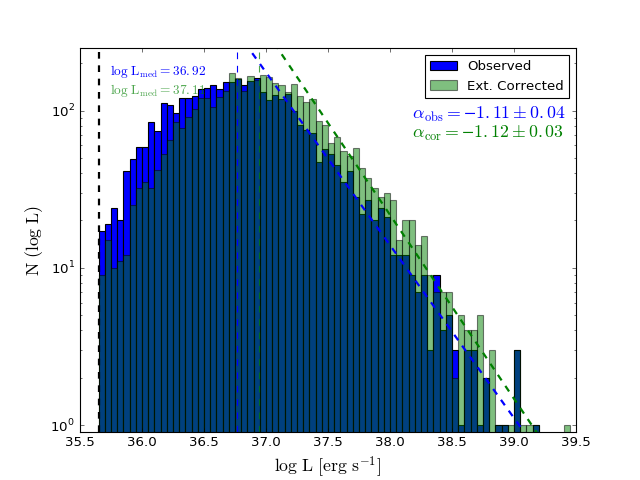

36.7659540132
36.9471443971
42.9098972731
-1.09985024822
45.7720669648
-1.17013906146


In [5]:
%matplotlib nbagg
bb=80
# L detection thresold 
y=plt.hist(lumi[(lumi > 35.65)], bins = bb, range=(35.5,39.5), log=True, label='Observed')
plt.xlabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', fontname='Helvetica',fontsize=16)
plt.ylabel('$\mathrm{N\,\,(log\,\,L)}$', fontname='Helvetica',fontsize=16)
plt.axvline(35.65, color='k', linestyle='--', linewidth = 2)
print np.median(lumi[(lumi > 35.65)])
print np.median(lumi2[(lumi2 > 35.65)])


yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=31
k=5
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--b', linewidth = 2 ) 

plt.ylim(0.9,250)
plt.xlim(35,39.5)
plt.annotate(r'$\alpha$'+'$\mathrm{_{obs} = \minus1.11\pm0.04}$',xy=(0.67,0.815),xycoords='axes fraction',\
            fontsize=16.0, color='b')

y=plt.hist(lumi2[(lumi2 > 35.65)], bins = bb, range=(35.5,39.5), log=True, alpha=0.5, label='Ext. Corrected')


yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=35
k=5
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--g', linewidth = 2 ) 
plt.axvline(np.median(lumi[(lumi > 35.65)]), color='b', linestyle='--')
plt.axvline(np.median(lumi2[(lumi2 > 35.65)]), color='g', linestyle='--', alpha=0.7)

plt.ylim(0.9,250)
plt.xlim(35.5,39.5)
plt.annotate(r'$\alpha$'+'$\mathrm{_{cor} = \minus1.12\pm0.03}$',xy=(0.67,0.765),xycoords='axes fraction',\
            fontsize=16.0, color='g')
plt.legend(loc='upper right',fontsize=12)

plt.annotate('$\mathrm{log\,\,L_{med} = 36.92}$',xy=(0.06,0.93),xycoords='axes fraction',\
            fontsize=12.0, color='b')
plt.annotate('$\mathrm{log\,\,L_{med} = 37.11}$',xy=(0.06,0.88),xycoords='axes fraction',\
            fontsize=12.0, color='g', alpha=0.7)

In [17]:
# Save the Plot in a .eps or .png file
plt.savefig('Lum_all.png', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [6]:
# Luminosity function of two subsamples using a thresold on the galactocentric radius (ra) map.

flux_tot2 = np.zeros(len(regx))
flux_tot3 = np.zeros(len(regx))
flux_tot4 = np.zeros(len(regx))
flux_tot5 = np.zeros(len(regx))


for i in range(0,len(regx)) :
    flux_tot2[i] = lumi2[i]
    flux_tot3[i] = lumi2[i]
    flux_tot4[i] = lumi2[i]
    flux_tot5[i] = lumi2[i]
    if ra[regy[i]-1,regx[i]-1] < 6500:
        flux_tot2[i] = 0
    if ra[regy[i]-1,regx[i]-1] >= 6500:
        flux_tot3[i] = 0
    if ra[regy[i]-1,regx[i]-1] < 8000:
        flux_tot4[i] = 0
    if ra[regy[i]-1,regx[i]-1] > 11000:
        flux_tot5[i] = 0

print np.median(flux_tot2[np.where(flux_tot2 > 0)[0]]) # sample 1 median
print np.median(flux_tot3[np.where(flux_tot3 > 0)[0]]) # sample 2 median
print len(np.where(flux_tot2 > 35.65)[0]) # sample 1 size
print len(np.where(flux_tot3 > 35.65)[0]) # sample 2 size

36.8652043111
37.0127860894
2087
2071


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


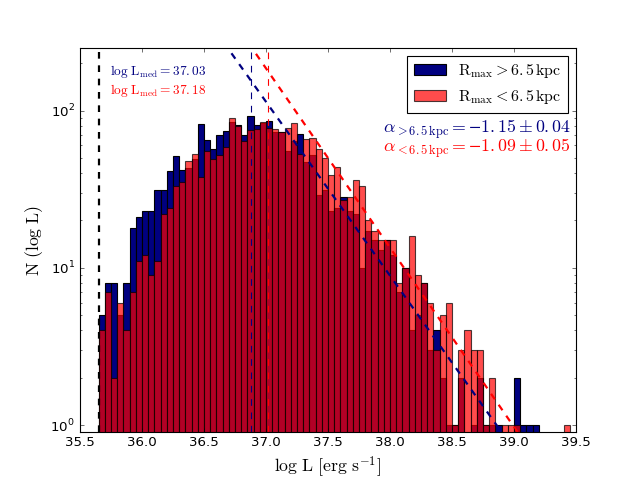

42.9786637995
-1.10676667004
44.4605605181
-1.14109523564
36.8652043111
37.0127860894


In [7]:
%matplotlib nbagg
y=plt.hist(flux_tot2[(lumi2 > 35.65)], bins = 80, range=(35.5,39.5),log=True, \
         color=(0,0,0.5),label='$\mathrm{R_{max}>6.5\,kpc}$')
yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=35
k=9
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--',color=(0,0,0.5), linewidth = 2 ) 

y=plt.hist(flux_tot3[(lumi2 > 35.65)], bins = 80, range=(35.5,39.5),log=True,alpha=0.7, \
         color='r', label='$\mathrm{R_{max}<6.5\,kpc}$')
yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=38
k=9
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--r', linewidth = 2 ) 

plt.ylim(0.9,250)
plt.xlim(35.5,39.5)
plt.xlabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', fontname='Helvetica',fontsize=16)
plt.ylabel('$\mathrm{N\,\,(log\,\,L)}$', fontname='Helvetica',fontsize=16)
plt.legend(loc='upper right')
plt.axvline(np.median(flux_tot2[np.where(flux_tot2 > 35.65)[0]]), color=(0,0,0.5), linestyle='--')
plt.axvline(np.median(flux_tot3[np.where(flux_tot3 > 35.65)[0]]), color='r', linestyle='--')
plt.axvline(35.65, color='k', linestyle='--', linewidth = 2)
#plt.axvline(np.median(flux_tot4[np.where(flux_tot4 > 0)[0]]), color='g', linestyle='--')
#plt.axvline(np.median(flux_tot5[np.where(flux_tot5 > 0)[0]]), color='purple', linestyle='--')
print np.median(flux_tot2[np.where(flux_tot2 > 0)[0]])
print np.median(flux_tot3[np.where(flux_tot3 > 0)[0]])

plt.annotate('$\mathrm{log\,\,L_{med} = 37.03}$',xy=(0.06,0.93),xycoords='axes fraction',\
            fontsize=12.0, color=(0,0,0.5))
plt.annotate('$\mathrm{log\,\,L_{med} = 37.18}$',xy=(0.06,0.88),xycoords='axes fraction',\
            fontsize=12.0, color='r')
plt.annotate(r'$\alpha$'+'$\mathrm{_{>6.5\,kpc} = \minus1.15\pm0.04}$',xy=(0.61,0.78),xycoords='axes fraction',\
            fontsize=16.0, color=(0,0,0.5))
plt.annotate(r'$\alpha$'+'$\mathrm{_{<6.5\,kpc} = \minus1.09\pm0.05}$',xy=(0.61,0.73),xycoords='axes fraction',\
            fontsize=16.0, color='r')

In [21]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_in_out.png', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

2084
2132


<IPython.core.display.Javascript object>


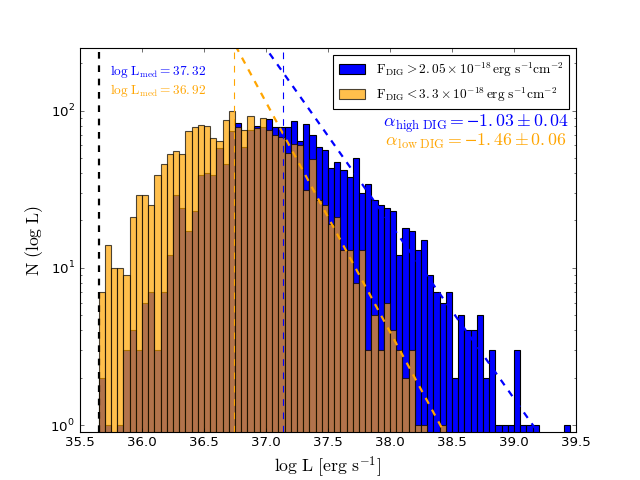

43.5854832427
-1.11400157322
56.1063405168
-1.46188908067
37.1361994735
36.7538028869


In [8]:
%matplotlib nbagg
# Luminosity function of two subsamples using a thresold on the galactocentric radius (ra) map.

flux_tot6 = np.zeros(len(regx))
flux_tot7 = np.zeros(len(regx))

for i in range(0,len(regx)) :
    flux_tot6[i] = lumi2[i]
    flux_tot7[i] = lumi2[i]
    if med[i] < 2.05e-18:
        flux_tot6[i] = 0
    if med[i] > 2.05e-18:
        flux_tot7[i] = 0

#print np.median(flux_tot6[np.where(flux_tot6 > 0)[0]]) # sample 1 median
#print np.median(flux_tot7[np.where(flux_tot7 > 0)[0]]) # sample 2 median
print len(np.where(flux_tot6 > 0)[0]) # sample 1 size
print len(np.where(flux_tot7 > 0)[0]) # sample 2 size
y=plt.hist(flux_tot6[(lumi2 > 35.65)], bins = 80, range=(35.5,39.5),log=True, color='b', label=r'$\mathrm{F_{DIG}>2.05\times10^{-18}\,erg\,\,s^{-1}cm^{-2}}$')


yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=40
k=5
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1)

print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--b', linewidth = 2 ) 

y=plt.hist(flux_tot7[(lumi2 > 35.65)], bins = 80, range=(35.5,39.5),log=True,alpha=0.7, \
         color='orange', label=r'$\mathrm{F_{DIG}<3.3\times10^{-18}\,erg\,\,s^{-1}cm^{-2}}$')

yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=33
k=18
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--',c='orange', linewidth = 2 ) 
plt.ylim(0.9,250)
plt.xlim(35.5,39.5)
plt.xlabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', fontname='Helvetica',fontsize=16)
plt.ylabel('$\mathrm{N\,\,(log\,\,L)}$', fontname='Helvetica',fontsize=16)
plt.legend(loc='upper right',fontsize=12)
plt.axvline(np.median(flux_tot6[np.where(flux_tot6 > 0)[0]]), color='b', linestyle='--')
plt.axvline(np.median(flux_tot7[np.where(flux_tot7 > 0)[0]]), color='orange', linestyle='--')
plt.axvline(35.65, color='k', linestyle='--', linewidth = 2)
#plt.axvline(np.median(flux_tot4[np.where(flux_tot4 > 0)[0]]), color='g', linestyle='--')
#plt.axvline(np.median(flux_tot5[np.where(flux_tot5 > 0)[0]]), color='purple', linestyle='--')
print np.median(flux_tot6[np.where(flux_tot6 > 35.65)[0]])
print np.median(flux_tot7[np.where(flux_tot7 > 35.65)[0]])

plt.annotate('$\mathrm{log\,\,L_{med} = 37.32}$',xy=(0.06,0.93),xycoords='axes fraction',\
            fontsize=12.0, color='b')
plt.annotate('$\mathrm{log\,\,L_{med} = 36.92}$',xy=(0.06,0.88),xycoords='axes fraction',\
            fontsize=12.0, color='orange')
plt.annotate(r'$\alpha$'+'$\mathrm{_{high\,\,DIG} = \minus1.03\pm0.04}$',xy=(0.61,0.795),xycoords='axes fraction',\
            fontsize=16.0, color='b')
plt.annotate(r'$\,\alpha$'+'$\mathrm{_{low\,\,DIG} = \minus1.46\pm0.06}$',xy=(0.61,0.745),xycoords='axes fraction',\
            fontsize=16.0, color='orange')

In [24]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_DIG.png', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

# Halpha flux profile of typical regions

1.65331e-16
112.5
[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # function evals   = 246
    # data points      = 117
    # variables        = 3
    chi-square         = 5.9288979e-32
    reduced chi-square = 0.000
    Akaike info crit   = -8963.812
    Bayesian info crit = -8955.525
[[Variables]]
    amplitude:   2.8655e-14 (init= 1.983975e-14)
    sigma:       65.3973166 (init= 30)
    center:      0 (fixed)
    fraction:    0.88477298 (init= 0)
    fwhm:        130.794633  == '2.0000000*sigma'
[[Correlations]] (unreported correlations are <  0.250)

1.47116539116e-16 3.27180041639e-17 65.3973166678 0.884772984026


<IPython.core.display.Javascript object>


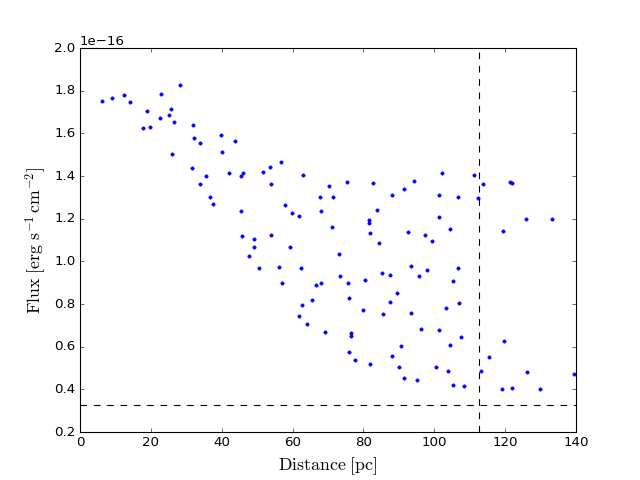

1.7983454328e-16


In [9]:
%matplotlib nbagg

name = 'Transient'
i=2223

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < 35)])
print maxi

x2 = dist[(dist < 300)]
y2 = flux_prof[(dist < 300)]-med[i]

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof[xx] = 0

x = dist[(flux_prof > 0) & (dist < 300)]
y = flux_prof[(flux_prof > 0) & (dist < 300)]-med[i]
print lim[i]
#print x
#print y

mod = PseudoVoigtModel()
mod.set_param_hint('amplitude', value = maxi*120, vary = maxi/100, )
mod.set_param_hint('sigma', value=30, max=90)
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0, min=0, max=0.9)
mod.set_param_hint('fwhm', value=80)
pars = mod.make_params()
out = mod.fit(y, pars, x=x, method='nelder')
params = out.params
#print mod.fit(y, pars, x=x)
#plt.plot(x,y,'.')
#plt.plot(np.arange(200),PseudoVoigtModel(1.35e-15,41,0,0.75,82.5), '.')
#plt.show
def pdv(x, a, cent,sig,frac):
    return (1-frac)*a*np.exp(-(x-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac*a*sig/(np.pi*((x-cent)**2+sig**2))
a = params['amplitude']
cent = params['center']
sig = params['sigma']
frac = params['fraction']
sigg = params['fwhm']
print(out.fit_report(min_correl=0.25))

print (1-frac)*a*np.exp(-(0)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*(0**2+sig**2)),med[i],sig*1,frac*1
plt.plot(x2, y2+med[i], '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
#plt.plot(np.arange(lim[i]), (1-frac)*a*np.exp(-(np.arange(lim[i])-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
#            frac*a*sig/(np.pi*((np.arange(lim[i])-cent)**2+sig**2))+med[i], 'k-')
print (1-frac)*a*np.exp(-(0)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*(0**2+sig**2))+med[i]
#plt.annotate(name,xy=(0.8,0.9),xycoords='axes fraction',\
#            fontsize=16.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold')
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
plt.show()

In [77]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_prof_lim_DIG.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

369
2.36864e-17
2.36864e-17
[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # function evals   = 168
    # data points      = 300
    # variables        = 3
    chi-square         = 2.351161e-33
    reduced chi-square = 0.000
    Akaike info crit   = -24244.254
    Bayesian info crit = -24233.143
[[Variables]]
    amplitude:   3.2413e-15 (init= 2.842368e-15)
    sigma:       63.4378873 (init= 30)
    center:      0 (fixed)
    fraction:    0.89999999 (init= 0)
    fwhm:        126.875774  == '2.0000000*sigma'
[[Correlations]] (unreported correlations are <  0.250)

(array([  2.10305325e-17]), 63.437887361184451, 0.89999999985479973)


<IPython.core.display.Javascript object>


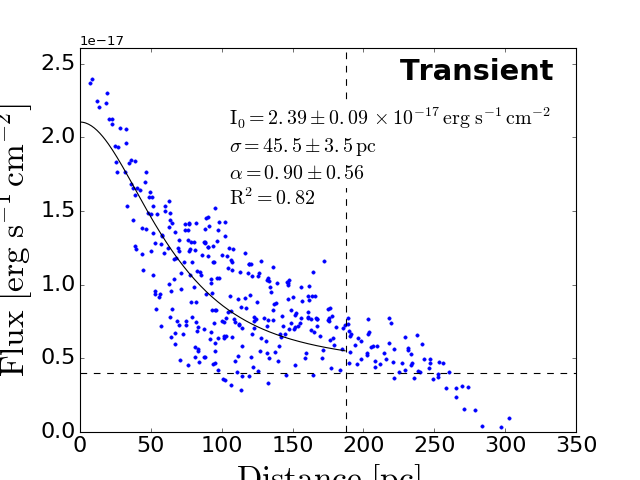

0.771422836883


In [10]:
%matplotlib nbagg

name = 'Transient'
i=2687

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0])# number of pixels

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+1)])
print maxi

medd=med[i]

x2 = dist[(dist < 350)]
y2 = flux_prof[(dist < 350)]-medd

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof[xx] = -10

x = dist[(flux_prof > -9) & (dist < lim[i])]
y = flux_prof[(flux_prof > -9) & (dist < lim[i])]-medd
print maxi
#print x
#print y

mod = PseudoVoigtModel()
mod.set_param_hint('amplitude', value = maxi*120, vary = maxi/100, )
mod.set_param_hint('sigma', value=30, max=90)
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0, min=0, max=0.9)
mod.set_param_hint('fwhm', value=80)
pars = mod.make_params()
out = mod.fit(y, pars, x=x, method='nelder')
params = out.params
#print mod.fit(y, pars, x=x)
#plt.plot(x,y,'.')
#plt.plot(np.arange(200),PseudoVoigtModel(1.35e-15,41,0,0.75,82.5), '.')
#plt.show
a = params['amplitude']
cent = params['center']
sig = params['sigma']
frac = params['fraction']
sigg = params['fwhm']

print(out.fit_report(min_correl=0.25))

print ( (1-frac)*a*np.exp(-(np.arange(1)-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(1)-cent)**2+sig**2))+medd,sig*1,frac*1)
plt.plot(x2, (y2+medd), '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
plt.plot(np.arange(lim[i]), ((1-frac)*a*np.exp(-(np.arange(lim[i])-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(lim[i])-cent)**2+sig**2))+medd), 'k-')

plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=30)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=30)
#plt.annotate('DIG Background',xy=(0.85,0.18),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold')
#plt.annotate('Outer Limit',xy=(0.52,0.735),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold', rotation=90)
plt.annotate(name,xy=(0.8,0.9),xycoords='axes fraction',\
            fontsize=26.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold')
plt.annotate(r'$\mathrm{I_{0} = 2.39\pm0.09\, \times 10^{-17}\,erg\,\,s^{-1}\,cm^{-2}}$',xy=(0.3,0.8),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor = 'w')
plt.annotate(r'$\mathrm{\sigma = 45.5\pm3.5\,pc}$',xy=(0.3,0.73),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor = 'w')
plt.annotate(r'$\mathrm{\alpha = 0.90\pm0.56}$',xy=(0.3,0.66),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor = 'w')
plt.annotate(r'$\mathrm{R^2 = 0.82}$',xy=(0.3,0.59),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor = 'w')
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
R2 = np.corrcoef((y[(x < lim[i]) & (y > 0)]+medd),((1-frac)*a*np.exp(-(x[(x < lim[i]) & (y > 0)]-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((x[(x < lim[i]) & (y > 0)]-cent)**2+sig**2))+medd))
print R2[0,1]
#print len(y2[x2 < lim[i]]+medd)
#print len(((1-frac)*a*np.exp(-(x2[(x2 < lim[i])]-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
#            frac*a*sig/(np.pi*(x2[(x2 < lim[i])]-cent)**2+sig**2))+medd))
#plt.set_xticklabels(fontsize=20.0)
plt.xticks(fontsize=20.0)
plt.yticks(fontsize=20.0)
plt.ylim(-0.,1.1*maxi)
plt.xlim(0,350)
plt.show()

In [221]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_prof_fila.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

381
1.3191e-17
1.3191e-17
[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # function evals   = 222
    # data points      = 280
    # variables        = 3
    chi-square         = 1.7435226e-33
    reduced chi-square = 0.000
    Akaike info crit   = -22691.973
    Bayesian info crit = -22681.069
[[Variables]]
    amplitude:   2.2172e-15 (init= 1.582924e-15)
    sigma:       59.9999985 (init= 30)
    center:      0 (fixed)
    fraction:    0.89999999 (init= 0)
    fwhm:        119.999997  == '2.0000000*sigma'
[[Correlations]] (unreported correlations are <  0.250)

(array([  1.41028882e-17]), 59.999998512271532, 0.89999999713522671)


<IPython.core.display.Javascript object>


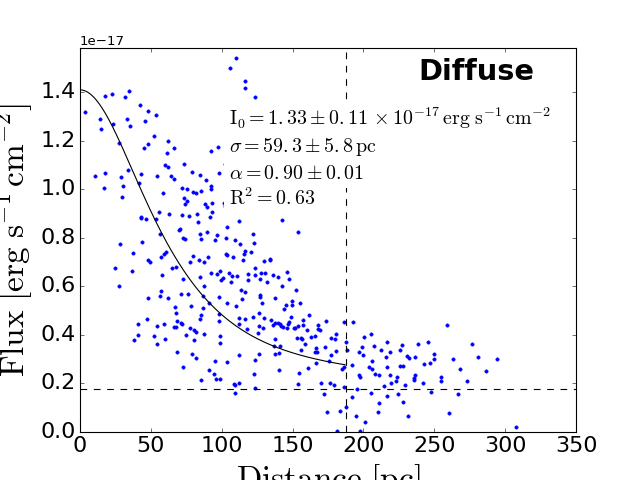

[[ 1.          0.64341761]
 [ 0.64341761  1.        ]]


In [11]:
%matplotlib nbagg

name = 'Diffuse'
i=833

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0])# number of pixels

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+1)])
print maxi

medd=med[i]

x2 = dist[(dist < 350)]
y2 = flux_prof[(dist < 350)]-medd

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof[xx] = -10

x = dist[(flux_prof > -9) & (dist < lim[i])]
y = flux_prof[(flux_prof > -9) & (dist < lim[i])]-medd
print maxi
#print x
#print y

mod = PseudoVoigtModel()
mod.set_param_hint('amplitude', value = maxi*120, vary = maxi/100, )
mod.set_param_hint('sigma', value=30, max=60)
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0, min=0, max=0.9)
mod.set_param_hint('fwhm', value=80)
pars = mod.make_params()
out = mod.fit(y, pars, x=x, method='nelder')
params = out.params
#print mod.fit(y, pars, x=x)
#plt.plot(x,y,'.')
#plt.plot(np.arange(200),PseudoVoigtModel(1.35e-15,41,0,0.75,82.5), '.')
#plt.show
a = params['amplitude']
cent = params['center']
sig = params['sigma']
frac = params['fraction']
sigg = params['fwhm']

print(out.fit_report(min_correl=0.25))

print ( (1-frac)*a*np.exp(-(np.arange(1)-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(1)-cent)**2+sig**2))+medd,sig*1,frac*1)
plt.plot(x2, (y2+medd), '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
plt.plot(np.arange(lim[i]), ((1-frac)*a*np.exp(-(np.arange(lim[i])-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(lim[i])-cent)**2+sig**2))+medd), 'k-')

plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=30)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=30)
#plt.annotate('DIG Background',xy=(0.85,0.14),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold')
#plt.annotate('Outer Limit',xy=(0.52,0.735),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold', rotation=90)
plt.annotate(name,xy=(0.8,0.9),xycoords='axes fraction',\
            fontsize=26.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold')
plt.annotate(r'$\mathrm{I_{0} = 1.33\pm0.11\, \times 10^{-17}\,erg\,\,s^{-1}\,cm^{-2}}$',xy=(0.3,0.8),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor='w')
plt.annotate(r'$\mathrm{\sigma = 59.3\pm5.8\,pc}$',xy=(0.3,0.73),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor='w')
plt.annotate(r'$\mathrm{\alpha = 0.90\pm0.01}$',xy=(0.3,0.66),xycoords='axes fraction',\
            fontsize=18.0, color='k',backgroundcolor='w')
plt.annotate(r'$\mathrm{R^2 = 0.63}$',xy=(0.3,0.59),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor = 'w')
R2 = np.corrcoef((y[(x < lim[i]) & (y > 0)]+medd),((1-frac)*a*np.exp(-(x[(x < lim[i]) & (y > 0)]-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((x[(x < lim[i]) & (y > 0)]-cent)**2+sig**2))+medd))
print R2
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.xticks(fontsize=20.0)
plt.yticks(fontsize=20.0)
plt.ylim(-0.,1.2*maxi)
plt.xlim(0,350)
plt.show()

In [223]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_prof_diff.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

352
1.16213e-15
1.16213e-15
[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # function evals   = 176
    # data points      = 352
    # variables        = 3
    chi-square         = 2.6794507e-31
    reduced chi-square = 0.000
    Akaike info crit   = -26836.871
    Bayesian info crit = -26825.280
[[Variables]]
    amplitude:   1.0438e-13 (init= 1.394556e-13)
    sigma:       35.7042290 (init= 30)
    center:      0 (fixed)
    fraction:    0.37933663 (init= 0)
    fwhm:        71.4084580  == '2.0000000*sigma'
[[Correlations]] (unreported correlations are <  0.250)

(array([  1.22450826e-15]), 35.704229000021755, 0.37933663178457994)


<IPython.core.display.Javascript object>


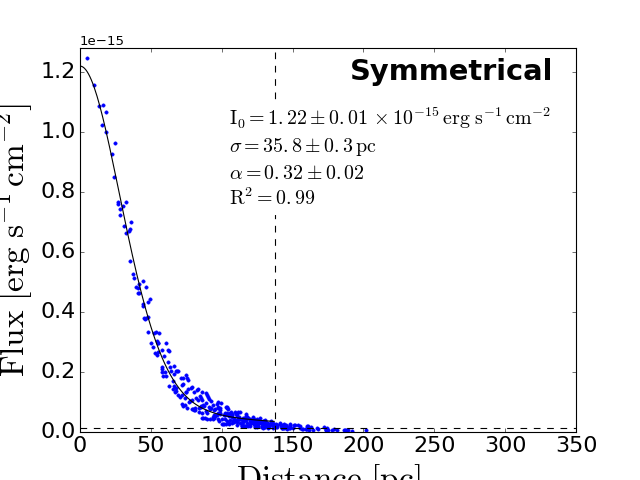

[[ 1.          0.99199701]
 [ 0.99199701  1.        ]]


In [12]:
%matplotlib nbagg

name ='Symmetrical'
i=2436

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0])# number of pixels
xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < 15)])
print maxi

x2 = dist[(dist < 300)]
y2 = flux_prof[(dist < 300)]-med[i]

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof[xx] = 0

x = dist[(flux_prof > 0) & (dist < 300)]
y = flux_prof[(flux_prof > 0) & (dist < 300)]-med[i]
print maxi
#print x
#print y

mod = PseudoVoigtModel()
mod.set_param_hint('amplitude', value = maxi*120, vary = maxi/100, )
mod.set_param_hint('sigma', value=30, max=90)
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0, min=0, max=0.9)
mod.set_param_hint('fwhm', value=80)
pars = mod.make_params()
out = mod.fit(y, pars, x=x, method='nelder')
params = out.params
#print mod.fit(y, pars, x=x)
#plt.plot(x,y,'.')
#plt.plot(np.arange(200),PseudoVoigtModel(1.35e-15,41,0,0.75,82.5), '.')
#plt.show
a = params['amplitude']
cent = params['center']
sig = params['sigma']
frac = params['fraction']
sigg = params['fwhm']

print(out.fit_report(min_correl=0.25))

print ( (1-frac)*a*np.exp(-(np.arange(1)-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(1)-cent)**2+sig**2))+med2[i],sig*1,frac*1)
plt.plot(x2, (y2+med[i]), '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
plt.plot(np.arange(lim[i]), ((1-frac)*a*np.exp(-(np.arange(lim[i])-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(lim[i])-cent)**2+sig**2))+med[i]), 'k-')
plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=30)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=30)
plt.annotate(name,xy=(0.75,0.9),xycoords='axes fraction',\
            fontsize=26.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold')
plt.annotate(r'$\mathrm{I_{0} = 1.22\pm0.01\, \times 10^{-15}\,erg\,\,s^{-1}\,cm^{-2}}$',xy=(0.3,0.8),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor='w')
plt.annotate(r'$\mathrm{\sigma = 35.8\pm0.3\,pc}$',xy=(0.3,0.73),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor='w')
plt.annotate(r'$\mathrm{\alpha = 0.32\pm0.02}$',xy=(0.3,0.66),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor='w')
plt.annotate(r'$\mathrm{R^2 = 0.99}$',xy=(0.3,0.59),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor = 'w')
R2 = np.corrcoef((y[(x < lim[i]) & (y > 0)]+medd),((1-frac)*a*np.exp(-(x[(x < lim[i]) & (y > 0)]-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((x[(x < lim[i]) & (y > 0)]-cent)**2+sig**2))+medd))
print R2
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.ylim(-0.,maxi*1.1)
plt.xticks(fontsize=20.0)
plt.yticks(fontsize=20.0)
plt.xlim(0,350)
plt.show()

In [225]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_prof_sph.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

291
1.47173e-15
1.47173e-15
[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # function evals   = 47
    # data points      = 291
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -21443.768
    Bayesian info crit = -21432.748
[[Variables]]
    amplitude:   1.9163e-13 +/- 3.45e-15 (1.80%) (init= 1.766078e-13)
    sigma:       44.9596976 +/- 1.118463 (2.49%) (init= 30)
    center:      0 (fixed)
    fraction:    0.73596721 +/- 0.054896 (7.46%) (init= 0)
    fwhm:        89.9193952 +/- 2.236927 (2.49%)  == '2.0000000*sigma'
[[Correlations]] (unreported correlations are <  0.250)
    C(sigma, fraction)           = -0.697 
    C(amplitude, fraction)       =  0.694 
    C(amplitude, sigma)          = -0.414 

(array([  1.57161253e-15]), 44.9596976001764, 0.7359672195665219)


<IPython.core.display.Javascript object>


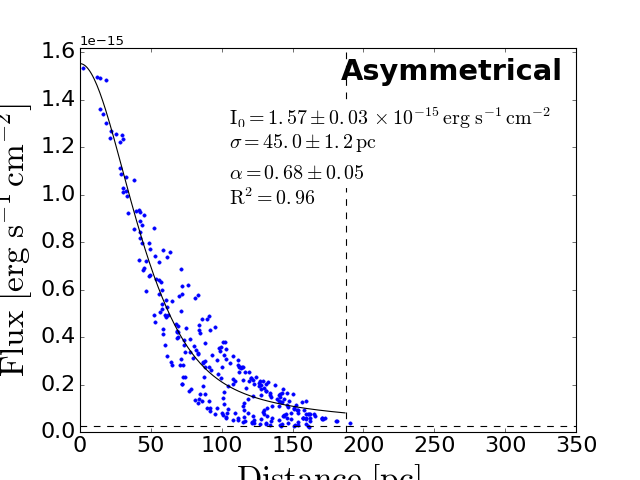

[[ 1.          0.95603938]
 [ 0.95603938  1.        ]]


In [13]:
%matplotlib nbagg

name = 'Asymmetrical'
i=2986

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0])# number of pixels
xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < 15)])
print maxi

x2 = dist[(dist < 300)]
y2 = flux_prof[(dist < 300)]-med[i]

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof[xx] = 0

x = dist[(flux_prof > 0) & (dist < 300)]
y = flux_prof[(flux_prof > 0) & (dist < 300)]-med[i]
print maxi
#print x
#print y

mod = PseudoVoigtModel()
mod.set_param_hint('amplitude', value = maxi*120, vary = maxi/100, )
mod.set_param_hint('sigma', value=30, max=90)
mod.set_param_hint('center', value=0, vary=0)
mod.set_param_hint('fraction', value=0, min=0, max=0.9)
mod.set_param_hint('fwhm', value=80)
pars = mod.make_params()
out = mod.fit(y, pars, x=x)
params = out.params
#print mod.fit(y, pars, x=x)
#plt.plot(x,y,'.')
#plt.plot(np.arange(200),PseudoVoigtModel(1.35e-15,41,0,0.75,82.5), '.')
#plt.show
a = params['amplitude']
cent = params['center']
sig = params['sigma']
frac = params['fraction']
sigg = params['fwhm']

print(out.fit_report(min_correl=0.25))

print ( (1-frac)*a*np.exp(-(np.arange(1)-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(1)-cent)**2+sig**2))+med2[i],sig*1,frac*1)
plt.plot(x2, (y2+med[i]), '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
plt.plot(np.arange(lim[i]), ((1-frac)*a*np.exp(-(np.arange(lim[i])-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((np.arange(lim[i])-cent)**2+sig**2))+med[i]), 'k-')
plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=30)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=30)
plt.annotate(name,xy=(0.75,0.9),xycoords='axes fraction',\
            fontsize=26.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold')
plt.annotate(r'$\mathrm{I_{0} = 1.57\pm0.03\, \times 10^{-15}\,erg\,\,s^{-1}\,cm^{-2}}$',xy=(0.3,0.8),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor='w')
plt.annotate(r'$\mathrm{\sigma = 45.0\pm1.2\,pc}$',xy=(0.3,0.74),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor='w')
plt.annotate(r'$\mathrm{\alpha = 0.68\pm0.05}$',xy=(0.3,0.66),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor='w')
plt.annotate(r'$\mathrm{R^2 = 0.96}$',xy=(0.3,0.59),xycoords='axes fraction',\
            fontsize=18.0, color='k', backgroundcolor = 'w')
R2 = np.corrcoef((y[(x < lim[i]) & (y > 0)]+medd),((1-frac)*a*np.exp(-(x[(x < lim[i]) & (y > 0)]-cent)**2/(2*(sig/(2*np.log(2))**0.5)**2))/((sig/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac*a*sig/(np.pi*((x[(x < lim[i]) & (y > 0)]-cent)**2+sig**2))+medd))
print R2
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.xticks(fontsize=20.0)
plt.yticks(fontsize=20.0)
plt.ylim(-0.,1.1*maxi)
plt.xlim(0,350)
plt.show()

In [227]:
#Save the Plot in a .eps or .png file
plt.savefig('Lum_prof_asym.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [16]:
# To find posible errors with low flux regions
print np.where((flux_tot < 5e-17))

(array([   5,    6,    7,   10,   13,   14,   16,   31,   35,   49,  104,
        109,  112,  131,  139,  148,  180,  217,  220,  245,  295,  336,
        441,  495,  531,  581,  590,  593,  669,  704,  788,  796,  800,
        806,  809,  837,  844,  859,  861,  910,  925,  938,  963,  982,
        983,  991, 1004, 1012, 1014, 1020, 1045, 1094, 1100, 1112, 1130,
       1152, 1154, 1345, 1349, 1418, 1437, 1474, 1491, 1566, 1570, 1593,
       1601, 1614, 1717, 1718, 1738, 1748, 1800, 1872, 1881, 1883, 1896,
       1899, 1960, 1970, 1994, 1996, 2007, 2049, 2068, 2070, 2109, 2132,
       2138, 2165, 2166, 2194, 2205, 2270, 2314, 2361, 2383, 2399, 2447,
       2451, 2468, 2478, 2493, 2526, 2538, 2568, 2627, 2628, 2653, 2694,
       2696, 2776, 2791, 2796, 2805, 2823, 2843, 2862, 2909, 2918, 2933,
       3004, 3010, 3025, 3028, 3056, 3063, 3079, 3087, 3088, 3174, 3255,
       3302, 3322, 3343, 3359, 3365, 3375, 3579, 3623, 3625, 3634, 3635,
       3704, 3714, 3719, 3729, 3734, 3771, 3778, 3

<IPython.core.display.Javascript object>


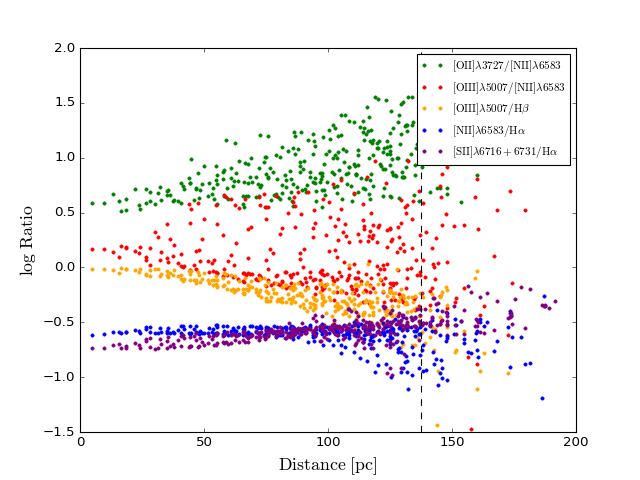

3.0


In [87]:
# To check the profile of some random regions "i"
cat = fits.getdata('NGC628_regions_category.fits')
on = fits.getdata('OII_NII_cut.fits')
o3n = fits.getdata('NGC628_ratio_OIII_NII_carte.fits')
o3h = fits.getdata('OIII_hb_cut.fits')
on2 = fits.getdata('NGC628_ratio_OII_NII_carte_i.fits')
on3 = fits.getdata('NGC628_ratio_OII_NII_carte.fits')
nh = fits.getdata('NGC628_ratio_NII_Ha_carte.fits')
sh = fits.getdata('SII_ha_cut.fits')

o3h = np.log10(o3h)
sh = np.log10(sh)
on = np.log10(on)

%matplotlib nbagg
i=2436

name = 'Spherical'

 
onr = np.array(len(np.where(grow == i+1)[0]))
on2r = np.array(len(np.where(grow == i+1)[0]))
on3r = np.array(len(np.where(grow == i+1)[0]))
o3nr = np.array(len(np.where(grow == i+1)[0]))
o3hr = np.array(len(np.where(grow == i+1)[0]))
nhr = np.array(len(np.where(grow == i+1)[0]))
shr = np.array(len(np.where(grow == i+1)[0]))
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy=np.where(grow == i+1)
dist=d[xxyy[0],xxyy[1]]
onr=on[xxyy[0],xxyy[1]]
on2r=on2[xxyy[0],xxyy[1]]
on3r=on3[xxyy[0],xxyy[1]]
o3nr=o3n[xxyy[0],xxyy[1]]
o3hr=o3h[xxyy[0],xxyy[1]]
nhr=nh[xxyy[0],xxyy[1]]
shr=sh[xxyy[0],xxyy[1]]

#plt.plot(dist[(on2r < 4)],on2r[(on2r < 4)],'.k', label='$\mathrm{[OII]\lambda3727/[NII]\lambda6583}$')
#plt.plot(dist[(on3r < 4)],on3r[(on3r < 4)],'.', c='g', label='$\mathrm{[OII]\lambda3727/[NII]\lambda6583}$')
#plt.plot(dist[(onr < 4)],onr[(onr < 4)],'.g', label='$\mathrm{[OII]\lambda3727/[NII]\lambda6583}$')
#plt.plot(dist[(o3nr < 10)],o3nr[(o3nr < 10)],'.r', label='$\mathrm{[OIII]\lambda5007/[NII]\lambda6583}$')
#plt.plot(dist[(o3hr < 10)],o3hr[(o3hr < 10)],'.', c='orange', label='$\mathrm{[OIII]\lambda5007/H}$'+r'$\mathrm{\beta}$')
#plt.plot(dist[(nhr < 2)],nhr[(nhr < 2)],'.b', label='$\mathrm{[NII]\lambda6583/H}$'+r'$\mathrm{\alpha}$')
#plt.plot(dist[(shr < 2)],shr[(shr < 2)],'.', c='purple', label='$\mathrm{[SII]\lambda6716+6731/H}$'+r'$\mathrm{\alpha}$')

#on = fits.getdata('NGC628_ratio_OII_NII_carte.fits')
#o3n = fits.getdata('NGC628_ratio_OIII_NII_carte.fits')
#o3h = fits.getdata('OIII_hb_cut.fits')
#nh = fits.getdata('NGC628_ratio_NII_Ha_carte.fits')
#sh = fits.getdata('SII_ha_cut.fits')
#
#o3h = np.log10(o3h)
#sh = np.log10(sh)
#
#%matplotlib nbagg
#i=2436
#
#name = 'Spherical'
#
# 
#onr = np.array(len(np.where(grow == i+1)[0]))
#o3nr = np.array(len(np.where(grow == i+1)[0]))
#o3hr = np.array(len(np.where(grow == i+1)[0]))
#nhr = np.array(len(np.where(grow == i+1)[0]))
#shr = np.array(len(np.where(grow == i+1)[0]))
#dist = np.array(len(np.where(grow == i+1)[0]))
#flux_prof = np.array(len(np.where(grow == i+1)[0]))
#
#xxyy=np.where(grow == i+1)
#dist=d[xxyy[0],xxyy[1]]
#onr=on[xxyy[0],xxyy[1]]
#o3nr=o3n[xxyy[0],xxyy[1]]
#o3hr=o3h[xxyy[0],xxyy[1]]
#nhr=nh[xxyy[0],xxyy[1]]
#shr=sh[xxyy[0],xxyy[1]]
#
plt.plot(dist[(on3r < 4)],on3r[(on3r < 4)],'.g', label='$\mathrm{[OII]\lambda3727/[NII]\lambda6583}$')
plt.plot(dist[(o3nr < 10)],o3nr[(o3nr < 10)],'.r', label='$\mathrm{[OIII]\lambda5007/[NII]\lambda6583}$')
plt.plot(dist[(o3hr < 10)],o3hr[(o3hr < 10)],'.', c='orange', label='$\mathrm{[OIII]\lambda5007/H}$'+r'$\mathrm{\beta}$')
plt.plot(dist[(nhr < 2)],nhr[(nhr < 2)],'.b', label='$\mathrm{[NII]\lambda6583/H}$'+r'$\mathrm{\alpha}$')
plt.plot(dist[(shr < 2)],shr[(shr < 2)],'.', c='purple', label='$\mathrm{[SII]\lambda6716+6731/H}$'+r'$\mathrm{\alpha}$')
plt.ylabel('$\mathrm{log\,\,Ratio}$', fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
plt.legend(loc='upper right',fontsize=10)
plt.axvline(lim[i], color='k', linestyle='--')

plt.xlim(0,200)
plt.ylim(-1.5,2)
plt.show()
print cat[2223]


In [202]:
#Save the Plot in a .eps or .png file
plt.savefig('Line_ratio2.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

<IPython.core.display.Javascript object>


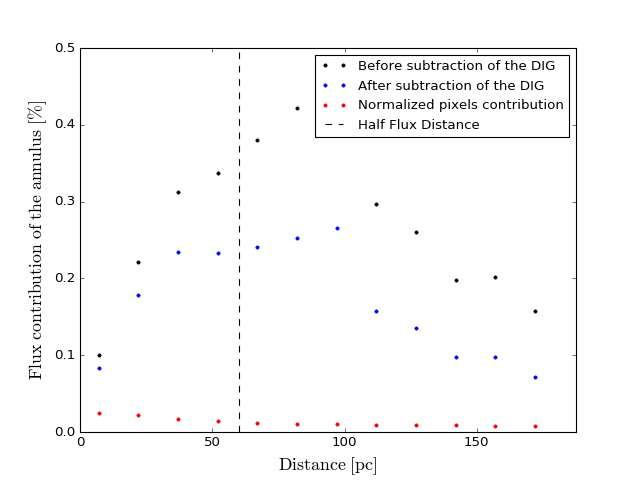

In [16]:
# To check the flux contribution of different distance annulus to the total flux 
# of some random regions "i"
%matplotlib nbagg

name = 'test'
i = 2687

h=15
n = int((lim[i]-lim[i]%h)/h)
#print n

dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy=np.where(grow == i+1)
dist=d[xxyy[0],xxyy[1]]
flux_prof=flux[xxyy[0],xxyy[1]]


fl = np.zeros(n)
fl2 = np.zeros(n)
fll = np.zeros(n)
fll2 = np.zeros(n)
flll2 = np.zeros(n)
dl = np.zeros(n)
#print np.max(flux_prof)
#print med[i]

for j in range(0,n) :
    fl[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)]-med[i])
    fl2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)])
    fll2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)]-med[i])/len(flux_prof[(dist < j*h+h) & (dist > j*h)])
    flll2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)])/len(flux_prof[(dist < j*h+h) & (dist > j*h)])
    dl[j] = j*h
    fll[0] = fl[0]/flux_tot[i]
    fll[j] = np.sum(fl[0:j])/flux_tot[i]

#print fll
#print np.sum(fll[0:(lim[i]+12.5/25)])
#print dl[(fll > 0.5)][0]
#print lim[i]
plt.ylabel('$\mathrm{Flux\,\,contribution\,\,of\,\,the\,\,annulus\,\,[\%]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#max = np.mean(fl[(dl == np.min(dl))])
#plt.ylim(-0.5,1)
plt.xlim(0,lim[i])
plt.plot( dl+h/2, fl2/flux_tot[i], '.k', label='Before subtraction of the DIG')
plt.plot( dl+h/2, fl/flux_tot[i], '.b', label='After subtraction of the DIG')
plt.plot( dl+h/2, flll2/flux_tot[i], '.r',label='Normalized pixels contribution')
plt.axvline(dl[(fll > 0.5)][0], color='k', linestyle='--',label='Half Flux Distance' )
#plt.plot( dl+h/2, fll2/flux_tot[i], '.r')
plt.legend(loc='upper right',fontsize=12)
plt.show()


In [494]:
#Save the Plot in a .eps or .png file
plt.savefig('Flux_DIF_contribution.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

12


<IPython.core.display.Javascript object>


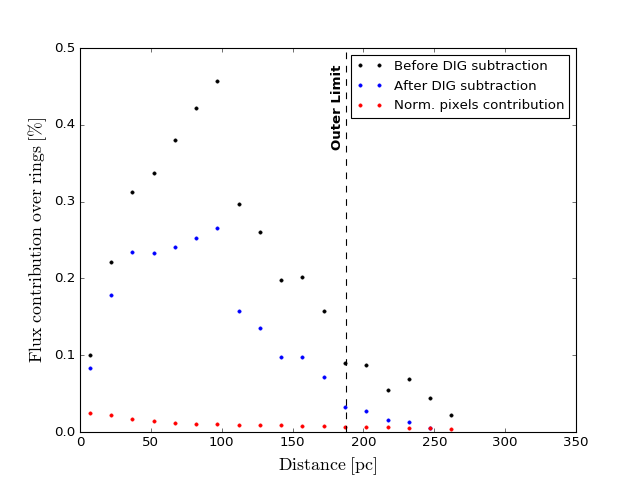

In [17]:
# To check the flux contribution of different distance annulus to the total flux 
# of some random regions "i"
%matplotlib nbagg

name = 'test'
i = 2687

h=15
n = int((lim[i]-lim[i]%h)/h)
print n
n=18
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy=np.where(grow == i+1)
dist=d[xxyy[0],xxyy[1]]
flux_prof=flux[xxyy[0],xxyy[1]]


fl = np.zeros(n)
fl2 = np.zeros(n)
fll = np.zeros(n)
fll2 = np.zeros(n)
flll2 = np.zeros(n)
dl = np.zeros(n)
#print np.max(flux_prof)
#print med[i]

for j in range(0,n) :
    fl[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)])-len(flux_prof[(dist < j*h+h) & (dist > j*h)])*med[i] 
    fl2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)])
    fll2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)]-med[i])/len(flux_prof[(dist < j*h+h) & (dist > j*h)])
    flll2[j]= np.sum(flux_prof[(dist < j*h+h) & (dist > j*h)])/len(flux_prof[(dist < j*h+h) & (dist > j*h)])
    dl[j] = j*h
    fll[0] = fl[0]/flux_tot[i]
    fll[j] = np.sum(fl[0:j])/flux_tot[i]

#print fll
#print np.sum(fll[0:(lim[i]+12.5/25)])
#print dl[(fll > 0.5)][0]
#print lim[i]
plt.ylabel('$\mathrm{Flux\,\,contribution\,\,over\,\,rings\,\,[\%]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#max = np.mean(fl[(dl == np.min(dl))])
plt.ylim(-0.0,0.5)
plt.xlim(0,350)
plt.plot( dl+h/2, fl2/flux_tot[i], '.k', label='Before DIG subtraction')
plt.plot( dl+h/2, fl/flux_tot[i], '.b', label='After DIG subtraction')
plt.plot( dl+h/2, flll2/flux_tot[i], '.r',label='Norm. pixels contribution')
#plt.axvline(dl[(fll > 0.5)][0], color='k', linestyle='--',label='Half Flux Distance' )
plt.axvline(lim[i], color='k', linestyle='--' )
#plt.plot( dl+h/2, fll2/flux_tot[i], '.r')
plt.annotate('Outer Limit',xy=(0.52,0.735),xycoords='axes fraction',\
            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
             color='k', fontname='times', fontweight='bold', rotation=90)
plt.legend(loc='upper right',fontsize=12)
plt.show()


In [512]:
#Save the Plot in a .eps or .png file
plt.savefig('Flux_DIG_cont_lim.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [18]:
xc=np.zeros(16)
xc[0:16]=[1,25,50,100,150,200,350,500,1000,2000,5000,10000,20000,50000,100000,200000]
xc=np.log10(xc)
q=np.zeros(16)
r1=np.zeros(16)
r10=np.zeros(16)
r100=np.zeros(16)
r500=np.zeros(16)
r10075=np.zeros(16)
r10050=np.zeros(16)
r10020=np.zeros(16)
r1000=np.zeros(16)
r100db=np.zeros(16)
ffa = 0.0005
q=5.0754 + 42.0340*xc - 15.0797*xc**2 + 2.4439*xc**3 - 0.1474*xc**4
for i in range(0,16):
    r1[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*1))**(1/3.0)/(3.085678e18)
    r10[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*100))**(1/3.0)/(3.085678e18)
    r100[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r500[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*250000))**(1/3.0)/(3.085678e18)
    r10075[i]=((3*10**q[i])/(4*3.14159*ffa*3.28*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r10050[i]=((3*10**q[i])/(4*3.14159*ffa*4.54*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r10020[i]=((3*10**q[i])/(4*3.14159*ffa*1.43*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r1000[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*1000000))**(1/3.0)/(3.085678e18)
#    r100db[i]=((10**q[i])/(4*3.14159*xc[i]**(0.333)*(ffa)**(0.66)*(100)**(1.66)))**(0.5)/(3.085678e18*1000)
    r100db[i]=(3*10**(q[i]-11.86)/(2.87*xc[i]*1.5e32*(1)**0.9*100))**(1/3.0)
    
r100db[0]=0


In [19]:
flux_max = np.zeros(4285)
flux_max2 = np.zeros(4285)

for i in range(0,4285):
    
    xxyy=np.where((grow == i+1) & (d < 50))
    flux_max[i] = np.max(flux[xxyy[0],xxyy[1]])
    flux_max2[i] = np.max(flux2[xxyy[0],xxyy[1]])

In [19]:
fits.writeto('NGC628_region_flux_max.fits', flux_max,clobber=True)
fits.writeto('NGC628_region_flux_max2.fits', flux_max2,clobber=True)

In [20]:
flux_max = fits.getdata('NGC628_region_flux_max.fits')
flux_max2 = fits.getdata('NGC628_region_flux_max2.fits')

In [21]:
mod = PseudoVoigtModel()
a = np.zeros(4285)
sig = np.zeros(4285)
fwhm = np.zeros(4285)
frac = np.zeros(4285)
amp = np.zeros(4285)

for i in range(0,4285):
    
    mod.set_param_hint('sigma', value=60, min=10, max=300)
    mod.set_param_hint('center', value=0, vary=0)
    mod.set_param_hint('fraction', value=0.5, min=0, max=1)
    mod.set_param_hint('fwhm', value=20)
    dist = np.array(len(np.where(grow == i+1)[0]))
    flux_prof = np.array(len(np.where(grow == i+1)[0]))
    xxyy = np.where(grow == i+1)
    dist = d[xxyy[0],xxyy[1]]
    flux_prof = flux2[xxyy[0],xxyy[1]]
    maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])
    
    xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
    flux_prof[xx] = -10
    xx = np.where((flux_prof/maxi > 1.2) & (dist > 10)) 
    flux_prof[xx] = -10

    x = dist[(flux_prof > -9) & (dist < lim[i]+50)]
    y = flux_prof[(flux_prof > -9) & (dist < lim[i]+50)]-med2[i]

    mod.set_param_hint('amplitude', value = maxi*100, min=maxi*10)
    pars = mod.make_params()
    out = mod.fit(y, pars, x=x, method='nelder', fit_kws={'nan_policy': 'omit'})
    params = out.params

    a[i] = np.float(params['amplitude'])
    sig[i] = np.float(params['sigma'])
    frac[i] = np.float(params['fraction'])
    fwhm[i] = np.float(params['fwhm'])
    amp[i] = ((1-frac[i])*a[i]*np.exp(-(0)**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac[i]*a[i]*sig[i]/(sig[i]**2))    
    
    
    if sig[i] > 200:
        
        x = dist[(flux_prof > 0) & (dist < 100)]
        y = flux_prof[(flux_prof > 0) & (dist < 100)]-med2[i]
        
        out = mod.fit(y, pars, x=x, method='nelder', fit_kws={'nan_policy': 'omit'})
        params = out.params
    
        a[i] = np.float(params['amplitude'])
        sig[i] = np.float(params['sigma'])
        frac[i] = np.float(params['fraction'])
        fwhm[i] = np.float(params['fwhm'])
        amp[i] = ((1-frac[i])*a[i]*np.exp(-(0)**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac[i]*a[i]*sig[i]/(sig[i]**2))
    
    if sig[i] > 200:
        
        x = dist[(flux_prof > 0) & (dist < 50)]
        y = flux_prof[(flux_prof > 0) & (dist < 50)]-med2[i]
        
        out = mod.fit(y, pars, x=x, method='nelder', fit_kws={'nan_policy': 'omit'})
        params = out.params
    
        a[i] = np.float(params['amplitude'])
        sig[i] = np.float(params['sigma'])
        frac[i] = np.float(params['fraction'])
        fwhm[i] = np.float(params['fwhm'])
        amp[i] = ((1-frac[i])*a[i]*np.exp(-(0)**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+frac[i]*a[i]*sig[i]/(sig[i]**2))

        

In [86]:
mod.fit?

In [45]:
fits.writeto('NGC628_voigt_amplitude.fits', a, clobber=True)
fits.writeto('NGC628_voigt_sigma.fits', sig, clobber=True)
fits.writeto('NGC628_voigt_fraction.fits', frac, clobber=True)
fits.writeto('NGC628_voigt_I0.fits', amp, clobber=True)



In [23]:
a = fits.getdata('NGC628_voigt_amplitude.fits')
sig = fits.getdata('NGC628_voigt_sigma.fits')
frac = fits.getdata('NGC628_voigt_fraction.fits')
amp = fits.getdata('NGC628_voigt_I0.fits')
print a

[  0.00000000e+00   0.00000000e+00   2.22044605e-16 ...,   1.22124533e-15
   4.44089210e-16   2.10942375e-15]


In [24]:
R2 = np.zeros(4285)
for i in range(0,4285):
    
    dist = np.array(len(np.where(grow == i+1)[0]))
    flux_prof = np.array(len(np.where(grow == i+1)[0]))
    xxyy = np.where(grow == i+1)
    dist = d[xxyy[0],xxyy[1]]
    flux_prof = flux2[xxyy[0],xxyy[1]]
    maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])
    
    xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
    flux_prof[xx] = -10
    xx = np.where((flux_prof/maxi > 1.2) & (dist > 10)) 
    flux_prof[xx] = -10

    x = dist[(flux_prof > -9) & (dist < lim[i]+50)]
    y = flux_prof[(flux_prof > -9) & (dist < lim[i]+50)]-med2[i]
    R = np.corrcoef((y[(x < lim[i]) & (y > 0)]+med2[i]),((1-frac[i])*a[i]*np.exp(-(x[(x < lim[i]) & (y > 0)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((x[(x < lim[i]) & (y > 0)])**2+sig[i]**2))+med2[i]))

    R2[i] = R[0,1]
fits.writeto('NGC628_voigt_correlation_coeff.fits', R2, clobber=True)


//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [25]:
R2 = fits.getdata('NGC628_voigt_correlation_coeff.fits')
print np.where((sig >160) & (R2 > 0.6))
#print len(R2[(R2 < 0.6)])

(array([ 766, 3021, 3039, 3482, 3905]),)


588
1.39115897506e-17
0.751311774338


<IPython.core.display.Javascript object>


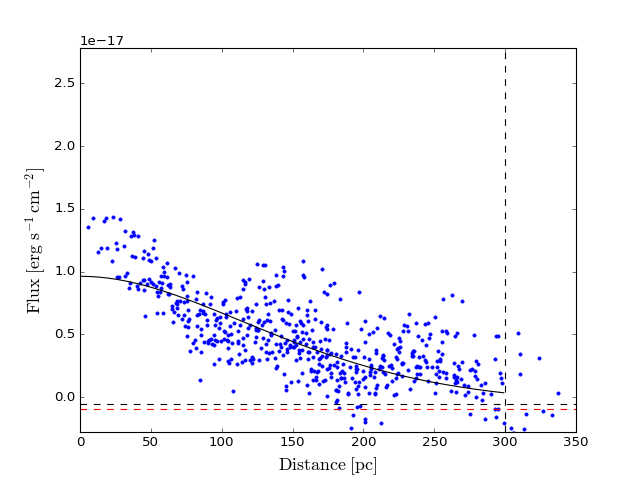

152.455203993
152.455203993
-9.82919766069e-19


In [26]:
%matplotlib nbagg

i=2893
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))
flux_prof2 = np.array(len(np.where(grow == i+1)[0]))
print len(np.where(grow == i+1)[0])# number of pixels

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux2[xxyy[0],xxyy[1]]
flux_prof2 = flux2[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])
print maxi

x2 = dist
y2 = flux_prof

xx = np.where((flux_prof/maxi > 0.6) & (dist > 100)) 
flux_prof2[xx] = -10
xx = np.where((flux_prof/maxi > 1.2) & (dist > 10)) 
flux_prof2[xx] = -10

x = dist[(flux_prof2 > -9) & (dist < lim[i]+50)]
y = flux_prof2[(flux_prof2 > -9) & (dist < lim[i]+50)]-med2[i]
#print x
#print y
print R2[i]

a2 = a[i]
cent2 = 0
sig2 = sig[i]
frac2 = frac[i]
sigg2 = 2*sig[i]
#print(out.fit_report(min_correl=0.25))

#print ( (1-frac2)*a2*np.exp(-(np.arange(1)-cent2)**2/(2*(sig2/(2*np.log(2))**0.5)**2))/((sig2/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
#            frac2*a2*sig/(np.pi*((np.arange(1)-cent2)**2+sig2**2)),med2[i],sig2*1,frac2*1)
plt.plot(x2, (y2), '.')
#plt.plot(x, out.init_fit+med[i], 'k--')
plt.plot(np.arange(lim[i]), ((1-frac2)*a2*np.exp(-(np.arange(lim[i])-cent2)**2/(2*(sig2/(2*np.log(2))**0.5)**2))/((sig2/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac2*a2*sig2/(np.pi*((np.arange(lim[i])-cent2)**2+sig2**2))+med2[i]), 'k-')
print sig[i]
plt.ylabel('$\mathrm{Flux\,\,[erg\,\,s^{-1}\,cm^{-2}]}$', fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Distance\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.annotate('DIG Background',xy=(0.85,0.14),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold')
#plt.annotate('Outer Limit',xy=(0.52,0.735),xycoords='axes fraction',\
#            fontsize=12.0, horizontalalignment='center',verticalalignment='bottom', \
#             color='k', fontname='times', fontweight='bold', rotation=90)
plt.axhline(med2[i], color='r', linestyle='--')
plt.axhline(med[i], color='k', linestyle='--')
plt.axvline(lim[i], color='k', linestyle='--')
plt.ylim(-0.2*maxi,2*maxi)
plt.xlim(0,350)
plt.show()
print sig[i]
print med2[i]

In [27]:

i=1000         
               
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux2[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])


print flux_prof[(dist > 0) & (dist < 15)]
print (1-frac[i])*a[i]*np.exp(-(dist[(dist > 0) & (dist < 15)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > 0) & (dist < 15)])**2+sig[i]**2))+med2[i]
print 'test'
print np.std(flux_prof[(dist > 0) & (dist < 15)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > 0) & (dist < 15)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > 0) & (dist < 15)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > 0) & (dist < 15)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
print np.std(flux_prof[(dist > sig[i]-8) & (dist < sig[i]+8)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > sig[i]-8) & (dist < sig[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > sig[i]-8) & (dist < sig[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > sig[i]-8) & (dist < sig[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
print np.std(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)

i=2687
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux2[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])

print 'transcient'
print np.std(flux_prof[(dist > 0) & (dist < 15)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > 0) & (dist < 15)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > 0) & (dist < 15)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > 0) & (dist < 15)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
print np.std(flux_prof[(dist > sig[i]-8) & (dist < sig[i]+8)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > sig[i]-8) & (dist < sig[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > sig[i]-8) & (dist < sig[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > sig[i]-8) & (dist < sig[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
print np.std(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)

i=833
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux2[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])

print 'diffuse'
print np.std(flux_prof[(dist > 0) & (dist < 15)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > 0) & (dist < 15)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > 0) & (dist < 15)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > 0) & (dist < 15)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
print np.std(flux_prof[(dist > sig[i]-8) & (dist < sig[i]+8)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > sig[i]-8) & (dist < sig[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > sig[i]-8) & (dist < sig[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > sig[i]-8) & (dist < sig[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
print np.std(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)


i=2436
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux2[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])

print 'symetrical'
print np.std(flux_prof[(dist > 0) & (dist < 15)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > 0) & (dist < 15)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > 0) & (dist < 15)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > 0) & (dist < 15)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
print np.std(flux_prof[(dist > sig[i]-8) & (dist < sig[i]+8)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > sig[i]-8) & (dist < sig[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > sig[i]-8) & (dist < sig[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > sig[i]-8) & (dist < sig[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
print np.std(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)

i=2986
dist = np.array(len(np.where(grow == i+1)[0]))
flux_prof = np.array(len(np.where(grow == i+1)[0]))

xxyy = np.where(grow == i+1)
dist = d[xxyy[0],xxyy[1]]
flux_prof = flux2[xxyy[0],xxyy[1]]
maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])

print 'Asymetrical'
print np.std(flux_prof[(dist > 0) & (dist < 15)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > 0) & (dist < 15)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > 0) & (dist < 15)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > 0) & (dist < 15)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
print np.std(flux_prof[(dist > sig[i]-8) & (dist < sig[i]+8)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > sig[i]-8) & (dist < sig[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > sig[i]-8) & (dist < sig[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > sig[i]-8) & (dist < sig[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
print np.std(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)])/maxi
print ((sqrt(mean(abs(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)


[  2.05223052e-17   2.15448140e-17   2.06934801e-17   2.16127714e-17]
[  1.75021508e-17   1.78618255e-17   1.72512669e-17   1.76018112e-17]
test
0.0226980957782
0.164859547099
0.119657071631
0.120018541359
0.107861481358
0.112435061422
transcient
0.0327724020204
0.094086784875
0.122420395158
0.13048693837
0.0428623919515
0.0530215355979
diffuse
0.0895234883138
0.175816644045
0.241399358475
0.271722831431
0.103893167696
0.107199223369
symetrical
0.0544785378399
0.0183613377527
0.0955001296516
0.0404762515373
0.00558722979535
0.0165390319775
Asymetrical
0.0420628633183
0.0499465733648
0.0864789943642
0.0694774751678
0.00276810868433
0.013989222208


In [28]:
devc = np.zeros(4285)
devs = np.zeros(4285)
devl= np.zeros(4285)
devc2 = np.zeros(4285)
devs2 = np.zeros(4285)
devl2 = np.zeros(4285)
temp = np.zeros(4285)

for i in range(0,4285):
    
    dist = np.array(len(np.where(grow == i+1)[0]))
    flux_prof = np.array(len(np.where(grow == i+1)[0]))

    xxyy = np.where(grow == i+1)
    dist = d[xxyy[0],xxyy[1]]
    flux_prof = flux2[xxyy[0],xxyy[1]]
    maxi = np.mean(flux_prof[(dist < np.min(dist)+5)])
    if sig[i] > lim[i]:
        temp[i] = lim[i]/2
    else:
        temp[i] = sig[i]

    devc[i] = np.std(flux_prof[(dist > 0) & (dist < 15)])/maxi
    devc2[i] = ((sqrt(mean(abs(flux_prof[(dist > 0) & (dist < 15)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > 0) & (dist < 15)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > 0) & (dist < 15)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
    devs[i] = np.std(flux_prof[(dist > temp[i]-8) & (dist < temp[i]+8)])/maxi
    devs2[i] = ((sqrt(mean(abs(flux_prof[(dist > temp[i]-8) & (dist < temp[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > temp[i]-8) & (dist < temp[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > temp[i]-8) & (dist < temp[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)
    devl[i] = np.std(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)])/maxi
    devl2[i] = ((sqrt(mean(abs(flux_prof[(dist > lim[i]-8) & (dist < lim[i]+8)] - \
            ((1-frac[i])*a[i]*np.exp(-(dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2/(2*(sig[i]/(2*np.log(2))**0.5)**2))/((sig[i]/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
            frac[i]*a[i]*sig[i]/(np.pi*((dist[(dist > lim[i]-8) & (dist < lim[i]+8)])**2+sig[i]**2))+med2[i]))**2)))/maxi)


//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [52]:
fits.writeto('NGC628_voigt_dev_center.fits', devc2, clobber=True)
fits.writeto('NGC628_mean_dev_center.fits', devc, clobber=True)
fits.writeto('NGC628_voigt_dev_sigma.fits', devs2, clobber=True)
fits.writeto('NGC628_mean_dev_sigma.fits', devs, clobber=True)
fits.writeto('NGC628_voigt_dev_limit.fits', devl2, clobber=True)
fits.writeto('NGC628_mean_dev_limit.fits', devl, clobber=True)

In [29]:
devc2 = fits.getdata('NGC628_voigt_dev_center.fits')
devc = fits.getdata('NGC628_mean_dev_center.fits')
devs2 = fits.getdata('NGC628_voigt_dev_sigma.fits')
devs = fits.getdata('NGC628_mean_dev_sigma.fits')
devl2 = fits.getdata('NGC628_voigt_dev_limit.fits')
devl = fits.getdata('NGC628_mean_dev_limit.fits')

In [23]:
cat = np.zeros(4285)
dev1 = np.zeros(4285)
dev2 = np.zeros(4285)
dev3 = np.zeros(4285)

for i in range(0,4285):
    
    if devc[i] < devc2[i] or np.isfinite(devc2[i]) == False:
        dev1[i] = devc[i]
    else: 
        dev1[i] = devc2[i]
        
    if devs[i] < devs2[i] or np.isfinite(devs2[i]) == False:
        dev2[i] = devs[i]
    else:
        dev2[i] = devs2[i]
        
    if devl[i] < devl2[i] or np.isfinite(devl2[i]) == False:
        dev3[i] = devl[i]
    else: 
        dev3[i] = devl2[i]
        
    if dev1[i] < 0.06 and dev2[i] < 0.06:
        cat[i] = 1 #'Symmetrical'
    if dev1[i] < 0.06 and dev2[i] > 0.06 and dev3[i] < 0.03:
        cat[i] = 2 #'Asymmetrical'
    if dev1[i] < 0.06 and dev2[i] > 0.06 and dev3[i] > 0.03:
        cat[i] = 3 #'Transcient'
    if dev1[i] > 0.06 and dev2[i] > 0.06:
        cat[i] = 4 #'Diffuse'
        

In [63]:
cat[(cat < 1)] = 4
fits.writeto('NGC628_regions_category.fits', cat, clobber=True)

In [30]:
cat = fits.getdata('NGC628_regions_category.fits')

In [31]:
i = 2986
print devl[i], dev2[i], dev3[i], cat[i]
print  len(np.where(cat == 1)[0])
print  len(np.where(cat == 2)[0])
print  len(np.where(cat == 3)[0])
print  len(np.where(cat == 4)[0])


0.00276810868433

NameError: name 'dev2' is not defined

In [ ]:
#from math import pi, sqrt, exp
#
#def gauss(n=50,sigma=35/2.35):
#    r = range(-int(n/2),int(n/2)+1)
#    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]
#print len(gauss())
#%matplotlib nbagg
#
#plt.plot(np.arange(51), gauss(), '.')
#plt.show()

In [ ]:
#pv = np.zeros(601)
#spv = np.zeros(601)
#fracc = 0
#sigt = 30
#a = 2.093746
#from scipy import signal
#
#for i in range(300,600):
#    i=i-300
#    pv[i+300] = ((1-fracc)*a*np.exp(-(i)**2/(2*(sigt/(2*np.log(2))**0.5)**2))/((sigt/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
#            fracc*a*sigt/(np.pi*((i)**2+sigt**2)))
##    spv[i+300] = np.sum(pv)
#    
#for i in range(0,299):
#    
#    pv[300-i] = ((1-fracc)*a*np.exp(-(i)**2/(2*(sigt/(2*np.log(2))**0.5)**2))/((sigt/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
#            fracc*a*sigt/(np.pi*((i)**2+sigt**2)))
##    spv[300-i] = np.sum(pv)
#
#
#print np.max(pv)
#
#%matplotlib nbagg
#
#plt.plot(np.arange(601), pv, '.')
#plt.plot(signal.deconvolve(pv,gauss())[0], '--')
#plt.plot(signal.deconvolve(signal.deconvolve(pv,gauss())[0],gauss())[0], '--y')
##plt.plot(np.arange(601), spv, '.')
##plt.plot(np.arange(497), recovered[0], '.', )
#plt.plot(gauss(), '.')
#plt.axvline(sigt, color='k', linestyle='--')
#plt.ylim(0,0.15)
#plt.show()


In [ ]:
#pv = np.zeros(601)
#spv = np.zeros(601)
#fracc = 0
#sigt = 30
#a = 2.093746
#from scipy import signal
#
#for i in range(300,600):
#    i=i-300
#    pv[i+300] = ((1-fracc)*a*np.exp(-(i)**2/(2*(sigt/(2*np.log(2))**0.5)**2))/((sigt/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
#            fracc*a*sigt/(np.pi*((i)**2+sigt**2)))
##    spv[i+300] = np.sum(pv)
#    
#for i in range(0,299):
#    
#    pv[300-i] = ((1-fracc)*a*np.exp(-(i)**2/(2*(sigt/(2*np.log(2))**0.5)**2))/((sigt/(2*np.log(2))**0.5)*(2*np.pi)**0.5)+\
#            fracc*a*sigt/(np.pi*((i)**2+sigt**2)))
##    spv[300-i] = np.sum(pv)
#
##recovered = signal.deconvolve(pv,gauss())
##print len(recovered[0])
#
##recovered2 = signal.deconvolve(recovered,gauss())
##print len(recovered[0])
##print len(recovered2[0])
#%matplotlib nbagg
#
#plt.plot(np.arange(601), pv, '.')
#plt.plot(np.arange(len(signal.convolve(gauss(),pv)))-25,signal.convolve(gauss(),pv), '.')
#plt.plot(np.arange(len(signal.convolve(gauss(),signal.convolve(gauss(),pv))))-50,signal.convolve(gauss(),signal.convolve(gauss(),pv)), '.')
#plt.plot(signal.deconvolve(signal.convolve(gauss(),signal.convolve(gauss(),pv)),gauss())[0], '--')
#plt.plot(signal.deconvolve(signal.deconvolve(signal.convolve(gauss(),signal.convolve(gauss(),pv)),gauss())[0],gauss())[0], '--y')
##plt.plot(np.arange(601), spv, '.') 
##plt.plot(np.arange(497), recovered[0], '.', )
##plt.plot(np.arange(105), gauss(), '.')
#plt.axvline(300+sigt, color='k', linestyle='--')
#plt.axvline(300-sigt, color='k', linestyle='--')
#plt.ylim(0,0.05)
#plt.show()


In [32]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return idx

In [33]:
fonction = fits.getdata('FWHM_sphere_int_uniform.fits')
sigf = deepcopy(sig)
for i in range(0,4285):
    if sig[i] > 290: 
        sigf[i] = 300
    else:
        #print sig[i]
        sigf[i] = find_nearest(fonction, sig[i])
    #print sigf[i]

In [92]:
fits.writeto('NGC628_regions_size.fits', sigf)

<IPython.core.display.Javascript object>


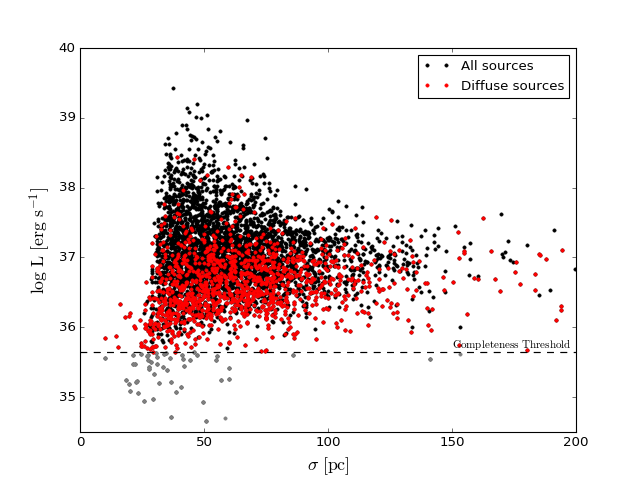

[35.781035157335566, 36.781035157335566, 37.781035157335566, 38.781035157335566, 39.781035157335566, 40.781035157335566]
[0.44209953728270357, 0.9524745795689005, 2.052044275596773, 4.420995372827034, 9.524745795689004, 20.52044275596773]


In [34]:
%matplotlib nbagg
j=0.4
jj=1.5e-17
plt.plot(sig[(sig > 0) & (med2/flux_max2 < j)], lumi2[(sig > 0) & (med2/flux_max2 < j)], '.', c='k',  label='All sources')

plt.plot(sig[(lumi2 < 35.65)], lumi2[(lumi2 < 35.65)], '.', c='grey')

plt.plot(sig[(cat == 4) & (lumi2 > 35.65)], lumi2[(cat == 4) & (lumi2 > 35.65)], '.', c='red',  label='Diffuse sources')
#plt.plot(sig[(cat == 3) & (lumi2 > 35.65)], lumi2[(cat == 3) & (lumi2 > 35.65)], '.', c='orange',  label='Transient sources')
#plt.plot(sig[(cat == 2) & (lumi2 > 35.65)], lumi2[(cat == 2) & (lumi2 > 35.65)], '.', c='green',  label='Asymmetrical sources')
#plt.plot(sig[(cat == 1) & (lumi2 > 35.65)], lumi2[(cat == 1) & (lumi2 > 35.65)], '.', c='blue',  label='Symmetrical sources')

yk = [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]
yk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk33 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk44 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk2 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk3 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk4 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
for i in range(0,9):
    yk[i] = np.log10(10**yk[i])
    xk[i] = (((xk[i]*3.085678*10**18)**3/10000)**0.33)/(3.085678*10**18)
    xk2[i] = (((xk2[i]*3.085678*10**18)**3*10)**0.33)/(3.085678*10**18)
    xk3[i] = (((xk3[i]*3.085678*10**18)**3/10)**0.33)/(3.085678*10**18)
    xk4[i] = xk4[i]*1.87
for i in range(0,6):
        yk22[i] = np.log10(yk22[i]*2e-8/912)
        xk22[i] = (3* xk22[i] / (2.59e-13*4*3.14159*100**2))**(1/3.0) / 3.085678e18
        xk33[i] = (3* xk33[i] / (2.59e-13*4*3.14159*10**2))**(1/3.0) / 3.085678e18
        xk44[i] = (3* xk44[i] / (2.59e-13*4*3.14159*1**2))**(1/3.0) / 3.085678e18
print yk22
print xk22

plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{\sigma\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=2) # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(r100,q-11.86, c='b',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10075,q-11.86, c=(0,0,0.4),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r1000,q-11.86, c='r', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1000 cm-3 for FMI and different mass
plt.axhline(35.65, color='k', linestyle='--')
plt.axhline(35.65, color='k', linestyle='--')
plt.xlim(0,200)
plt.ylim(34.5,40)
plt.show()
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1\,cm^{-3}}$',xy=(0.68,0.05),xycoords='axes fraction',\
#            fontsize=12.0, color='y')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}}$',xy=(0.67,0.455),xycoords='axes fraction',\
#            fontsize=12.0, color='g')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.65,0.81),xycoords='axes fraction',\
#            fontsize=12.0, color='b')
#plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.32,0.88),xycoords='axes fraction',\
#            fontsize=12.0, color=(0,0,0.4))
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}}$',xy=(0.24,0.95),xycoords='axes fraction',\
#            fontsize=12.0, color='r')
plt.annotate('$\mathrm{Completeness\,\,Threshold}$',xy=(0.75,0.22),xycoords='axes fraction',\
            fontsize=10.0, color='k')
plt.legend(loc='upper right',fontsize=12)


In [73]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_lumi_vs_sigma_voigt.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [71]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_lumi_vs_sigma_voigt1.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [73]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_lumi_vs_sigma_voigt2.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [75]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_lumi_vs_sigma_voigt3.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [77]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_lumi_vs_sigma_voigt4.eps', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

<IPython.core.display.Javascript object>


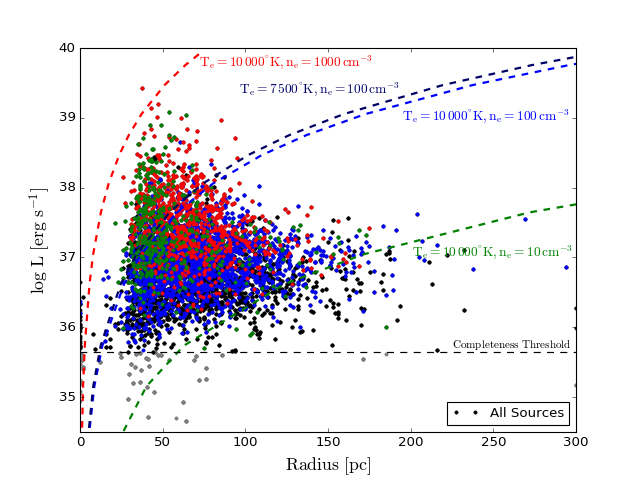

[35.781035157335566, 36.781035157335566, 37.781035157335566, 38.781035157335566, 39.781035157335566, 40.781035157335566]
[0.44209953728270357, 0.9524745795689005, 2.052044275596773, 4.420995372827034, 9.524745795689004, 20.52044275596773]


In [35]:
%matplotlib nbagg
j=0.4
jj=1.5e-17
plt.plot(sigf[(sigf > 0) & (med2/flux_max2 < j)], lumi2[(sigf > 0) & (med2/flux_max2 < j)], '.', c='k',  label='All Sources')
#plt.plot(sig[(sig > 0) & (med2 > jj) & (med2/flux_max2 < j) & (lumi2 > 35.65)], lumi2[(sig > 0) & (med2 > jj) & (med2/flux_max2 < j) & (lumi2 > 35.65)], '.', c='orange', label=r'$\mathrm{F_{DIG} > 1.5\times10^{-17}\,[erg\,\,s^{-1}\,\,cm^{-2}]}$')
plt.plot(sigf[(lumi2 < 35.65)], lumi2[(lumi2 < 35.65)], '.', c='grey')
#plt.plot(dlll[(dlll > 0) & (med < 2e-18)], lumi[(dlll > 0) & (med < 2e-18)], '.', c='r')
plt.plot(sigf[(cat == 4) & (lumi2 > 35.65)], lumi2[(cat == 4) & (lumi2 > 35.65)], '.', c='k')
plt.plot(sigf[(cat == 3) & (lumi2 > 35.65)], lumi2[(cat == 3) & (lumi2 > 35.65)], '.', c='blue')
plt.plot(sigf[(cat == 2) & (lumi2 > 35.65)], lumi2[(cat == 2) & (lumi2 > 35.65)], '.', c='red')
plt.plot(sigf[(cat == 1) & (lumi2 > 35.65)], lumi2[(cat == 1) & (lumi2 > 35.65)], '.', c='green')
#plt.plot(sig[(frac < 0.1)], lumi2[(frac < 0.1)], '.', c='purple')

yk = [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]
yk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk33 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk44 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk2 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk3 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk4 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
for i in range(0,9):
    yk[i] = np.log10(10**yk[i])
    xk[i] = (((xk[i]*3.085678*10**18)**3/10000)**0.33)/(3.085678*10**18)
    xk2[i] = (((xk2[i]*3.085678*10**18)**3*10)**0.33)/(3.085678*10**18)
    xk3[i] = (((xk3[i]*3.085678*10**18)**3/10)**0.33)/(3.085678*10**18)
    xk4[i] = xk4[i]*1.87
for i in range(0,6):
        yk22[i] = np.log10(yk22[i]*2e-8/912)
        xk22[i] = (3* xk22[i] / (2.59e-13*4*3.14159*100**2))**(1/3.0) / 3.085678e18
        xk33[i] = (3* xk33[i] / (2.59e-13*4*3.14159*10**2))**(1/3.0) / 3.085678e18
        xk44[i] = (3* xk44[i] / (2.59e-13*4*3.14159*1**2))**(1/3.0) / 3.085678e18
print yk22
print xk22
#plt.plot([1.87*156,1.87*129,1.87*104,1.87*86,1.87*69,1.87*55,1.87*38,1.87*26,1.87*8.8],\
#         [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]) # 20000 K, ne = np = 1 cm-3
#plt.plot(xk22,yk22, linestyle='dashed') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(xk33,yk22, linestyle='dashed') # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(xk44,yk22, linestyle='dashed') # 10000K, ne = np = 1 cm-3 for FMI and different mass
#plt.plot(xk,yk) # 10000K, ne = np = 100 cm-3
#plt.plot(xk2,yk) # 10000K, giant region ne = np = 100 cm-3, M_tot = 100000 Mstar
#plt.plot(xk3,yk) # 10000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
#plt.plot(xk4,yk) # 20000K, giant region ne = np = 10 cm-3, M_tot = 100000 Mstar
plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{Radius\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.plot(r1,q-11.51, c='y', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1 cm-3 for FMI and different mass
plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=2) # 10000K, ne = np = 10 cm-3 for FMI and different mass
plt.plot(r100,q-11.86, c='b',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r500,q-11.86, c='cyan',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r10075,q-11.86, c=(0,0,0.4),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10050,q-11.51, c=(0,0,0.8),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10020,q-11.51, c=(0,0,0.6),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r1000,q-11.86, c='r', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1000 cm-3 for FMI and different mass
plt.axhline(35.65, color='k', linestyle='--')
#plt.plot(r100db,q-11.86, c='purple', linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass, density bounded
plt.axhline(35.65, color='k', linestyle='--')
#print np.where(dlll[(np.where(dlll > 0))] < 10)
#plt.plot(dlll/lim, flux_tot, '.b')
plt.xlim(0,300)
plt.ylim(34.5,40)
plt.show()
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1\,cm^{-3}}$',xy=(0.68,0.05),xycoords='axes fraction',\
#            fontsize=12.0, color='y')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}}$',xy=(0.67,0.455),xycoords='axes fraction',\
            fontsize=12.0, color='g')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.65,0.81),xycoords='axes fraction',\
            fontsize=12.0, color='b')
plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.32,0.88),xycoords='axes fraction',\
            fontsize=12.0, color=(0,0,0.4))
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}}$',xy=(0.24,0.95),xycoords='axes fraction',\
            fontsize=12.0, color='r')
plt.annotate('$\mathrm{Completeness\,\,Threshold}$',xy=(0.75,0.22),xycoords='axes fraction',\
            fontsize=10.0, color='k')
plt.legend(loc='lower right',fontsize=12)


[35.781035157335566, 36.781035157335566, 37.781035157335566, 38.781035157335566, 39.781035157335566, 40.781035157335566]
[0.44209953728270357, 0.9524745795689005, 2.052044275596773, 4.420995372827034, 9.524745795689004, 20.52044275596773]


<IPython.core.display.Javascript object>


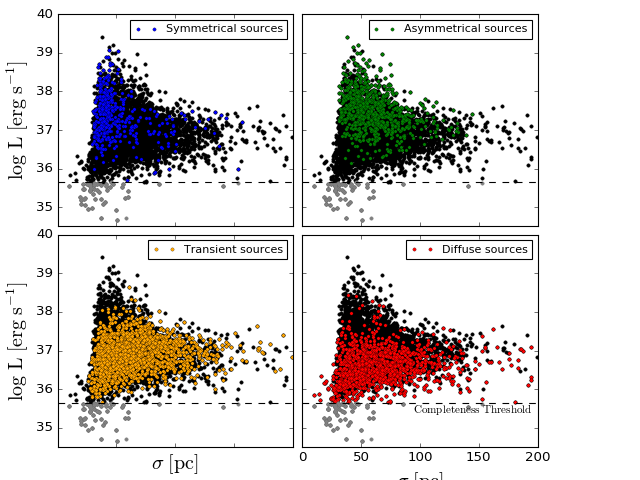

In [36]:
%matplotlib nbagg


j=0.4
jj=1.5e-17

yk = [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]
yk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk33 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk44 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk2 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk3 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk4 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
for i in range(0,9):
    yk[i] = np.log10(10**yk[i])
    xk[i] = (((xk[i]*3.085678*10**18)**3/10000)**0.33)/(3.085678*10**18)
    xk2[i] = (((xk2[i]*3.085678*10**18)**3*10)**0.33)/(3.085678*10**18)
    xk3[i] = (((xk3[i]*3.085678*10**18)**3/10)**0.33)/(3.085678*10**18)
    xk4[i] = xk4[i]*1.87
for i in range(0,6):
        yk22[i] = np.log10(yk22[i]*2e-8/912)
        xk22[i] = (3* xk22[i] / (2.59e-13*4*3.14159*100**2))**(1/3.0) / 3.085678e18
        xk33[i] = (3* xk33[i] / (2.59e-13*4*3.14159*10**2))**(1/3.0) / 3.085678e18
        xk44[i] = (3* xk44[i] / (2.59e-13*4*3.14159*1**2))**(1/3.0) / 3.085678e18
print yk22
print xk22

plt.close('all')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.

# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
ax1.plot(sig[(sig > 0) & (med2/flux_max2 < j)], lumi2[(sig > 0) & (med2/flux_max2 < j)], '.', c='k')
ax1.plot(sig[(cat == 1) & (lumi2 > 35.65)], lumi2[(cat == 1) & (lumi2 > 35.65)], '.', c='blue', markeredgecolor ='k', markeredgewidth = 0.2, label='Symmetrical sources')
ax1.plot(sig[(lumi2 < 35.65)], lumi2[(lumi2 < 35.65)], '.', c='grey')
ax2.plot(sig[(sig > 0) & (med2/flux_max2 < j)], lumi2[(sig > 0) & (med2/flux_max2 < j)], '.', c='k')
ax2.plot(sig[(cat == 2) & (lumi2 > 35.65)], lumi2[(cat == 2) & (lumi2 > 35.65)], '.', c='green', markeredgecolor ='k', markeredgewidth = 0.2,  label='Asymmetrical sources')
ax2.plot(sig[(lumi2 < 35.65)], lumi2[(lumi2 < 35.65)], '.', c='grey')
ax3.plot(sig[(sig > 0) & (med2/flux_max2 < j)], lumi2[(sig > 0) & (med2/flux_max2 < j)], '.', c='k')
ax3.plot(sig[(cat == 3) & (lumi2 > 35.65)], lumi2[(cat == 3) & (lumi2 > 35.65)], '.', c='orange', markeredgecolor ='k', markeredgewidth = 0.2, label='Transient sources')
ax3.plot(sig[(lumi2 < 35.65)], lumi2[(lumi2 < 35.65)], '.', c='grey')
ax4.plot(sig[(sig > 0) & (med2/flux_max2 < j)], lumi2[(sig > 0) & (med2/flux_max2 < j)], '.', c='k')
ax4.plot(sig[(cat == 4) & (lumi2 > 35.65)], lumi2[(cat == 4) & (lumi2 > 35.65)], '.', c='red', markeredgecolor ='k', markeredgewidth = 0.2, label='Diffuse sources')
ax4.plot(sig[(lumi2 < 35.65)], lumi2[(lumi2 < 35.65)], '.', c='grey')

plt.show()

ax1.set_ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=18)
ax3.set_ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=18)
ax3.set_xlabel('$\mathrm{\sigma\,\,[pc]}$', fontname='Helvetica',fontsize=18)
ax4.set_xlabel('$\mathrm{\sigma\,\,[pc]}$', fontname='Helvetica',fontsize=18)
ax1.axhline(35.65, color='k', linestyle='--')
ax2.axhline(35.65, color='k', linestyle='--')
ax3.axhline(35.65, color='k', linestyle='--')
ax4.axhline(35.65, color='k', linestyle='--')

ax1.set_xlim(0,200)
ax1.set_ylim(34.5,40)
ax2.set_xlim(0,200)
ax2.set_ylim(34.5,40)
ax3.set_xlim(0,200)
ax3.set_ylim(34.5,40)
ax4.set_xlim(0,200)
ax4.set_ylim(34.5,40)
plt.show()

plt.annotate('$\mathrm{Completeness\,\,Threshold}$',xy=(0.47,0.16),xycoords='axes fraction',\
            fontsize=10.0, color='k')
ax1.legend(loc='upper right',fontsize=10)
ax2.legend(loc='upper right',fontsize=10)
ax3.legend(loc='upper right',fontsize=10)
ax4.legend(loc='upper right',fontsize=10)

f.subplots_adjust(top=0.97)
f.subplots_adjust(bottom=0.069)
f.subplots_adjust(left=0.09)
f.subplots_adjust(right=0.84)
f.subplots_adjust(hspace=0.04)
f.subplots_adjust(wspace=0.04)

In [154]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_lumi_vs_sigma_voigt_all.png', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

<IPython.core.display.Javascript object>


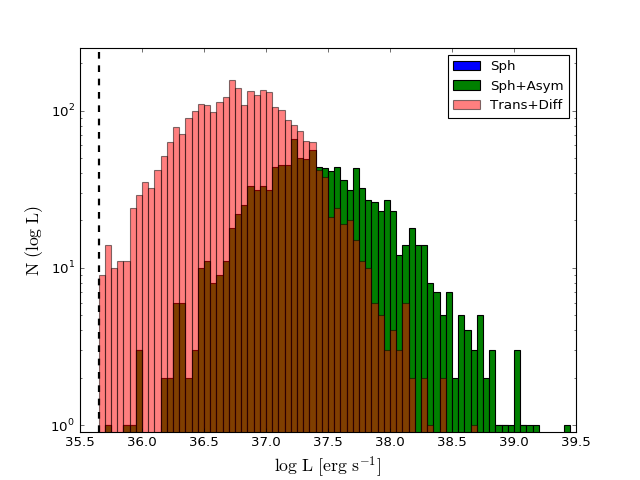

37.2711829025
28.6885714818
-0.7367043201
39.3735988377
-1.01573041551


In [37]:
%matplotlib nbagg
bb=80
# L detection thresold 
y=plt.hist(lumi2[(cat == 1) & (lumi2 > 35.65)], bins = bb, range=(35.5,39.5), log=True, label='Sph')
plt.xlabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', fontname='Helvetica',fontsize=16)
plt.ylabel('$\mathrm{N\,\,(log\,\,L)}$', fontname='Helvetica',fontsize=16)
plt.axvline(35.65, color='k', linestyle='--', linewidth = 2)
print np.median(lumi2[(cat == 1) & (lumi2 > 35.65)])


yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=31
k=5
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
#plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--b', linewidth = 2 ) 

plt.ylim(0.9,250)
plt.xlim(35,39.5)
#plt.annotate(r'$\alpha$'+'$\mathrm{_{obs} = \minus1.11\pm0.04}$',xy=(0.67,0.815),xycoords='axes fraction',\
#            fontsize=16.0, color='b')

y=plt.hist(lumi2[(cat < 2.5) & (lumi2 > 35.65)], bins = bb, range=(35.5,39.5), log=True, alpha=1, label='Sph+Asym')
y=plt.hist(lumi2[(cat > 2.5) & (lumi2 > 35.65)], bins = bb, range=(35.5,39.5), log=True, alpha=0.5, label='Trans+Diff')


yy = y[0]
xx = y[1]
yy = np.log10(yy)
yy[(np.isfinite(yy) == False)]=0
#print yy[l:bb-k]
#print xx[l:bb-k]

l=35
k=5
m,b = polyfit(xx[l:bb-k], (yy[l:bb-k]), 1) 
print b
print m
#plt.plot(xx[l-20:bb]+0.025,10**(m*xx[l-20:bb]+b), '--g', linewidth = 2 ) 
#plt.axvline(np.median(lumi2[(cat == 1) & (lumi2 > 35.65)]), color='g', linestyle='--', alpha=0.7)

plt.ylim(0.9,250)
plt.xlim(35.5,39.5)
#plt.annotate(r'$\alpha$'+'$\mathrm{_{cor} = \minus1.12\pm0.03}$',xy=(0.67,0.765),xycoords='axes fraction',\
#            fontsize=16.0, color='g')
plt.legend(loc='upper right',fontsize=12)

#plt.annotate('$\mathrm{log\,\,L_{med} = 36.92}$',xy=(0.06,0.93),xycoords='axes fraction',\
#            fontsize=12.0, color='b')
#plt.annotate('$\mathrm{log\,\,L_{med} = 37.11}$',xy=(0.06,0.88),xycoords='axes fraction',\
#            fontsize=12.0, color='g', alpha=0.7)

In [318]:
hahb = fits.getdata('NGC628_regions_hahb_ratio.fits')
hahbv = np.zeros(4285)

for i in range(0,4285):
    
    flux_prof = np.array(len(np.where(grow == i+1)[0]))

    xxyy = np.where(grow == i+1)
    hahbv[i] = np.mean(hahb[xxyy[0],xxyy[1]])

In [323]:
fits.writeto('NGC628_regions_hahbv.fits', hahbv)

In [38]:
hahbv = fits.getdata('NGC628_regions_hahbv.fits')


In [39]:
snr = fits.getdata('NGC628_SN2_1.0.LineMaps.map.4861.snr.clean.int3.fits')
sn = np.zeros(4285)

for i in range(0,4285):
    
    flux_prof = np.array(len(np.where(grow == i+1)[0]))

    xxyy = np.where(grow == i+1)
    sn[i] = np.mean(snr[xxyy[0],xxyy[1]])

In [26]:
fits.writeto('NGC628_regions_hbmean_snr.fits', sn)

In [40]:
sn = fits.getdata('NGC628_regions_hbmean_snr.fits')

<IPython.core.display.Javascript object>


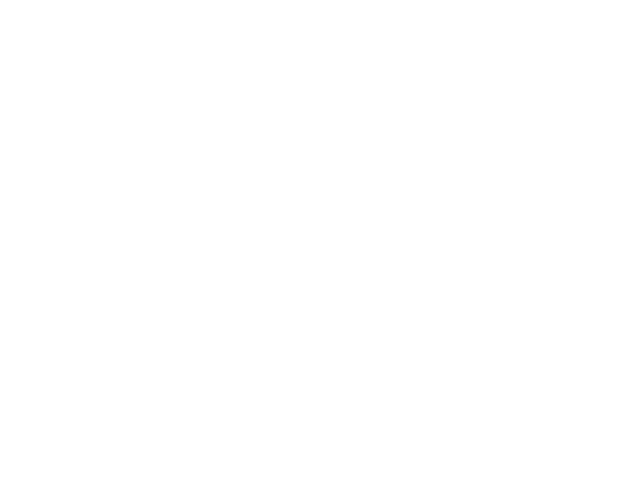

[35.781035157335566, 36.781035157335566, 37.781035157335566, 38.781035157335566, 39.781035157335566, 40.781035157335566]
[0.44209953728270357, 0.9524745795689005, 2.052044275596773, 4.420995372827034, 9.524745795689004, 20.52044275596773]


In [41]:
%matplotlib nbagg
j=1
jj=1.5e-17
plt.plot(sig[(sig > 0) & (med2/flux_max2 < j)], lumi2[(sig > 0) & (med2/flux_max2 < j)], '.', c='k')

plt.plot(sig[(lumi2 < 35.65)], lumi2[(lumi2 < 35.65)], '.', c='grey')

#plt.plot(sig[(cat == 4) & (lumi2 > 35.65)], lumi2[(cat == 4) & (lumi2 > 35.65)], '.', c='red',  label='Diffuse sources')
#plt.plot(sig[(cat == 3) & (lumi2 > 35.65)], lumi2[(cat == 3) & (lumi2 > 35.65)], '.', c='orange',  label='Transient sources')
#plt.plot(sig[(cat == 2) & (lumi2 > 35.65)], lumi2[(cat == 2) & (lumi2 > 35.65)], '.', c='green',  label='Asymmetrical sources')
plt.plot(sig[(hahbv < 2.87) & (sn > 3)], lumi2[(hahbv < 2.87) & (sn > 3)], '.', c='blue',  label=r'$\mathrm{\frac{H\alpha}{H\beta} < 2.87}$ sources')
plt.plot(sig[(hahbv > 2.87) & (sn > 3)], lumi2[(hahbv > 2.87) & (sn > 3)], '.', c='red',  label=r'$\mathrm{\frac{H\alpha}{H\beta} > 2.87}$ sources')

yk = [38.12,37.87,37.6,37.34,37.07,36.77,36.30,35.80,34.38]
yk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk22 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk33 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk44 = [10**46.44,10*10**46.44,100*10**46.44,1000*10**46.44,10000*10**46.44,100000*10**46.44]
xk = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk2 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk3 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
xk4 = [1.28*156,1.28*129,1.28*104,1.28*86,1.28*69,1.28*55,1.28*38,1.28*26,1.28*8.8]
for i in range(0,9):
    yk[i] = np.log10(10**yk[i])
    xk[i] = (((xk[i]*3.085678*10**18)**3/10000)**0.33)/(3.085678*10**18)
    xk2[i] = (((xk2[i]*3.085678*10**18)**3*10)**0.33)/(3.085678*10**18)
    xk3[i] = (((xk3[i]*3.085678*10**18)**3/10)**0.33)/(3.085678*10**18)
    xk4[i] = xk4[i]*1.87
for i in range(0,6):
        yk22[i] = np.log10(yk22[i]*2e-8/912)
        xk22[i] = (3* xk22[i] / (2.59e-13*4*3.14159*100**2))**(1/3.0) / 3.085678e18
        xk33[i] = (3* xk33[i] / (2.59e-13*4*3.14159*10**2))**(1/3.0) / 3.085678e18
        xk44[i] = (3* xk44[i] / (2.59e-13*4*3.14159*1**2))**(1/3.0) / 3.085678e18
print yk22
print xk22

plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=16)
plt.xlabel('$\mathrm{\sigma\,\,[pc]}$', fontname='Helvetica',fontsize=16)
#plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=2) # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(r100,q-11.86, c='b',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10075,q-11.86, c=(0,0,0.4),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r1000,q-11.86, c='r', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1000 cm-3 for FMI and different mass
plt.axhline(35.65, color='k', linestyle='--')
plt.axhline(35.65, color='k', linestyle='--')
plt.xlim(0,200)
plt.ylim(34.5,40)
plt.show()
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1\,cm^{-3}}$',xy=(0.68,0.05),xycoords='axes fraction',\
#            fontsize=12.0, color='y')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}}$',xy=(0.67,0.455),xycoords='axes fraction',\
#            fontsize=12.0, color='g')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.65,0.81),xycoords='axes fraction',\
#            fontsize=12.0, color='b')
#plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.32,0.88),xycoords='axes fraction',\
#            fontsize=12.0, color=(0,0,0.4))
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}}$',xy=(0.24,0.95),xycoords='axes fraction',\
#            fontsize=12.0, color='r')
plt.annotate('$\mathrm{Completeness\,\,Threshold}$',xy=(0.75,0.22),xycoords='axes fraction',\
            fontsize=10.0, color='k')
plt.legend(loc='upper right',fontsize=12)


<IPython.core.display.Javascript object>


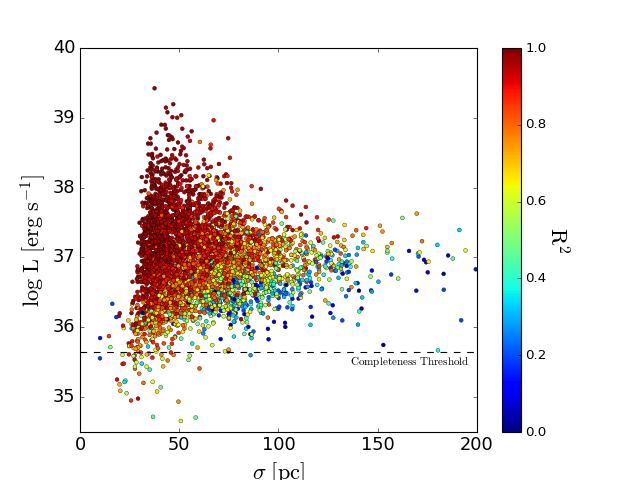

In [63]:
%matplotlib nbagg

j=1
jj=0
plt.scatter(sig[(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], lumi2[(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], marker='.', s=50,  edgecolors ='k',linewidth=0.3, c=R2[(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], linewidths = 0.0, alpha = 1)
cbar=plt.colorbar(ticks=[0,0.2,0.4,0.6,0.8,1.0],pad=0.05)
cbar.set_label('$\mathrm{R^2}$', rotation=270, fontsize=20, fontname = 'Helvetica', labelpad=20)

plt.clim(0,1)
plt.xticks(fontsize=16.0)
plt.yticks(fontsize=16.0)
#plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=2) # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(r100,q-11.86, c='b',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10075,q-11.86, c=(0,0,0.4),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r1000,q-11.86, c='r', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1000 cm-3 for FMI and different mass
#plt.axvline(32.8, color='k', linestyle='--')
#plt.annotate('$\mathrm{Sensitivity\,\,Threshold}$',xy=(0.13,0.96),xycoords='axes fraction',\
#            fontsize=10.0, color='k', rotation=90)
plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=20)
plt.xlabel('$\mathrm{\sigma\,\,[pc]}$', fontname='Helvetica',fontsize=20)
plt.axhline(35.65, color='k', linestyle='--')
plt.annotate('$\mathrm{Completeness\,\,Threshold}$',xy=(0.68,0.175),xycoords='axes fraction',\
            fontsize=10.0, color='k')

plt.xlim(0,200)
plt.ylim(34.5,40)
plt.show()

In [156]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_lumi_vs_sigma_vs_R2.png', transparent=True, bbox_inches='tight', pad_inches=0.04)
#plt.savefig('test.png', dpi=1000)

In [43]:
xc=np.zeros(18)
xc[0:18]=[1,25,50,100,150,200,350,500,1000,2000,5000,10000,20000,50000,100000,200000,300000,350000]
xc=np.log10(xc)
q=np.zeros(18)
r1=np.zeros(18)
r10=np.zeros(18)
r10_test=np.zeros(18)
r100=np.zeros(18)
r100_test=np.zeros(18)
r100_test2=np.zeros(18)
r100_test3=np.zeros(18)
r100_test4=np.zeros(18)
r500=np.zeros(18)
r10075=np.zeros(18)
r10050=np.zeros(18)
r10020=np.zeros(18)
r1000=np.zeros(18)
r100db=np.zeros(18)
ffa = 0.0005
q=5.0754 + 42.0340*xc - 15.0797*xc**2 + 2.4439*xc**3 - 0.1474*xc**4
for i in range(0,18):
    r1[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*1))**(1/3.0)/(3.085678e18)
    r10[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*100))**(1/3.0)/(3.085678e18)
    r10_test[i]=((3*10**q[i])/(4*3.14159*0.001*2.59*10**(-13)*100))**(1/3.0)/(3.085678e18)
    r100[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r100_test[i]=((3*10**q[i])/(4*3.14159*0.0001*2.59*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r100_test2[i]=((3*10**q[i])/(4*3.14159*0.001*2.59*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r100_test3[i]=((3*10**q[i])/(4*3.14159*0.00001*2.59*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r100_test4[i]=((3*10**q[i])/(4*3.14159*0.01*2.59*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r500[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*250000))**(1/3.0)/(3.085678e18)
    r10075[i]=((3*10**q[i])/(4*3.14159*ffa*3.28*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r10050[i]=((3*10**q[i])/(4*3.14159*ffa*4.54*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r10020[i]=((3*10**q[i])/(4*3.14159*ffa*1.43*10**(-13)*10000))**(1/3.0)/(3.085678e18)
    r1000[i]=((3*10**q[i])/(4*3.14159*ffa*2.59*10**(-13)*1000000))**(1/3.0)/(3.085678e18)
#    r100db[i]=((10**q[i])/(4*3.14159*xc[i]**(0.333)*(ffa)**(0.66)*(100)**(1.66)))**(0.5)/(3.085678e18*1000)
    r100db[i]=(3*10**(q[i]-11.86)/(2.87*xc[i]*1.5e32*(1)**0.9*100))**(1/3.0)
    
r100db[0]=0
print r1000
print q-11.86
lumi3 = 10**lumi2/10**36
print lumi3

[  1.95432472e-14   1.23811242e-02   1.48696965e-01   8.67621007e-01
   1.86632730e+00   2.91531354e+00   5.73983949e+00   7.94998358e+00
   1.26239924e+01   1.73036342e+01   2.36674061e+01   2.94892273e+01
   3.71715853e+01   5.11952853e+01   6.37279662e+01   7.35414137e+01
   7.50151209e+01   7.42992625e+01]
[ -6.7846      28.62069006  31.85931614  34.1574      35.15537325
  35.73646563  36.61910907  37.04350852  37.646       38.0568218
  38.46486181  38.7514      39.05304307  39.47009972  39.7554      39.94200574
  39.96785626  39.95536333]
[0.6095906539656202 0.6010268265567191 1.0531873481346294 ...,
 5.527422001293566 2.80482166066443 18.242466317663347]


<IPython.core.display.Javascript object>


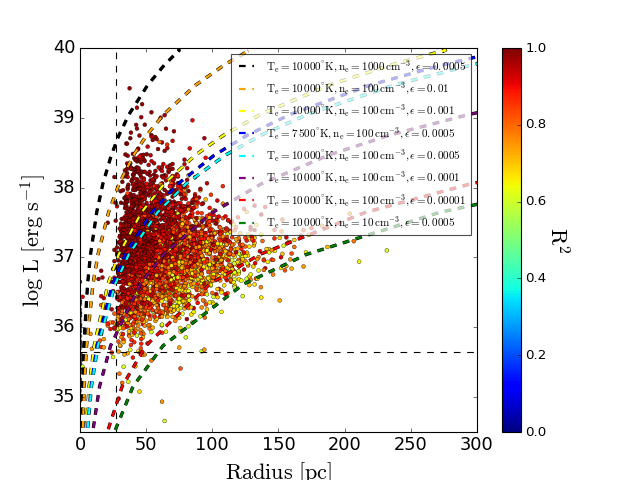

In [44]:
%matplotlib nbagg

j=1
jj=0.6
plt.scatter(sigf[(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], lumi2[(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], marker='.', edgecolors ='k',linewidth=0.3, s=50, c=R2[(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], linewidths = 0.0, alpha = 1)
cbar=plt.colorbar(ticks=[0,0.2,0.4,0.6,0.8,1.0],pad=0.05)
cbar.set_label('$\mathrm{R^2}$', rotation=270, fontsize=20, fontname = 'Helvetica', labelpad=20)
plt.axhline(35.65, color='k', linestyle='--')
plt.axvline(27.5, color='k', linestyle='--')



plt.clim(0,1)
plt.xticks(fontsize=16.0)
plt.yticks(fontsize=16.0)
plt.plot(r10,q-11.86,c='k', linestyle='dashed', linewidth=3) # 10000K, ne = np = 10 cm-3 for FMI and different mass
plt.plot(r100_test3,q-11.86, c='k',linestyle='dashed', linewidth=3)
plt.plot(r100_test,q-11.86, c='k',linestyle='dashed', linewidth=3)
plt.plot(r100,q-11.86, c='k',linestyle='dashed', linewidth=3)
plt.plot(r100_test2,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r100_test4,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r10075,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r1000,q-11.86, c='k', linestyle='dashed', linewidth=3) # 10000K, ne = np = 1000 cm-3 for FMI and different mass

plt.plot(r1000,q-11.86, c='k', linestyle='dashed', linewidth=2, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 1000 cm-3 for FMI and different mass
plt.plot(r100_test4,q-11.86, c='orange',linestyle='dashed', linewidth=2, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.01}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r100_test2,q-11.86, c='yellow',linestyle='dashed', linewidth=2, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r10075,q-11.86, c='b',linestyle='dashed', linewidth=2, label='$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r100,q-11.86, c='aqua',linestyle='dashed', linewidth=2, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r100_test,q-11.86, c='purple',linestyle='dashed', linewidth=2, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r100_test3,q-11.86, c='r',linestyle='dashed', linewidth=2, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.00001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=2, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 10 cm-3 for FMI and different mass

#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.36,0.95),xycoords='axes fraction',\
#            fontsize=12.0, color='r', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.33),xycoords='axes fraction',\
#            fontsize=12.0, color='g', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.76),xycoords='axes fraction',\
#            fontsize=12.0, color='b', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0001}$',xy=(0.39,0.7),xycoords='axes fraction',\
#            fontsize=12.0, color='purple', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.001}$',xy=(0.38,0.9),xycoords='axes fraction',\
#            fontsize=12.0, color='orange', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.85),xycoords='axes fraction',\
#            fontsize=12.0, color=(0,0,0.4), backgroundcolor = 'w')

plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=20)
plt.xlabel('$\mathrm{Radius\,\,[pc]}$', fontname='Helvetica',fontsize=20)
leg = plt.legend(loc='upper right',fontsize=10)
leg.get_frame().set_alpha(0.7)
plt.xlim(0,300)
plt.ylim(34.5,40)
plt.show()

In [28]:
#Save the Plot in a .eps or .png file
plt.savefig('NGC628_lumi_vs_radius_vs_R2.png', transparent=True, bbox_inches='tight', pad_inches=0.)
#plt.savefig('test.png', dpi=1000)

In [51]:
r_reg = fits.getdata('NGC628_regions_rayons.fits')
print r_reg

[ 12747.02734375  12490.5390625   12408.7109375  ...,  21771.71679688
  18736.61914062  22473.12304688]


<IPython.core.display.Javascript object>


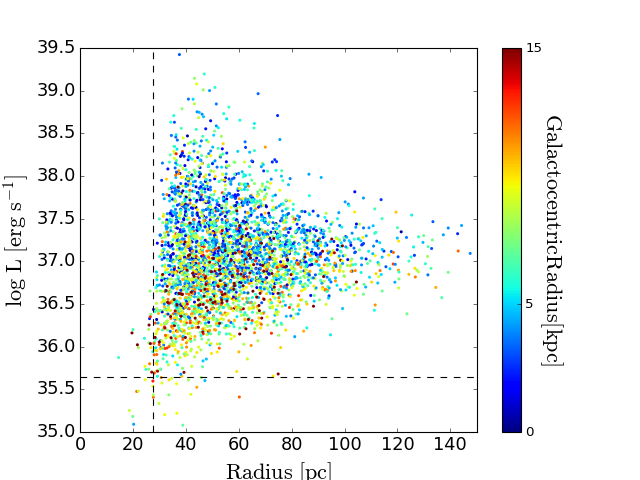

In [69]:
%matplotlib nbagg

j=1
jj=0.6
plt.scatter(sig[(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], lumi2[(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], marker='.', linewidth=0, s=30, c=r_reg[(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)]/1000, alpha = 1)
cbar=plt.colorbar(ticks=[0,5,15,20.0],pad=0.05)
cbar.set_label('$\mathrm{Galactocentric Radius [kpc]}$', rotation=270, fontsize=20, fontname = 'Helvetica', labelpad=20)
plt.axhline(35.65, color='k', linestyle='--')
plt.axvline(27.5, color='k', linestyle='--')



plt.clim(0,15)
plt.xticks(fontsize=16.0)
plt.yticks(fontsize=16.0)
#plt.plot(r10,q-11.86,c='k', linestyle='dashed', linewidth=3) # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(r100_test3,q-11.86, c='k',linestyle='dashed', linewidth=3)
#plt.plot(r100_test,q-11.86, c='k',linestyle='dashed', linewidth=3)
#plt.plot(r100,q-11.86, c='k',linestyle='dashed', linewidth=3)
#plt.plot(r100_test2,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test4,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10075,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r1000,q-11.86, c='k', linestyle='dashed', linewidth=3) # 10000K, ne = np = 1000 cm-3 for FMI and different mass

#plt.plot(r1000,q-11.86, c='k', linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 1000 cm-3 for FMI and different mass
#plt.plot(r100_test4,q-11.86, c='orange',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.01}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test2,q-11.86, c='yellow',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10075,q-11.86, c='b',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100,q-11.86, c='aqua',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test,q-11.86, c='purple',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test3,q-11.86, c='r',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.00001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 10 cm-3 for FMI and different mass

#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.36,0.95),xycoords='axes fraction',\
#            fontsize=12.0, color='r', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.33),xycoords='axes fraction',\
#            fontsize=12.0, color='g', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.76),xycoords='axes fraction',\
#            fontsize=12.0, color='b', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0001}$',xy=(0.39,0.7),xycoords='axes fraction',\
#            fontsize=12.0, color='purple', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.001}$',xy=(0.38,0.9),xycoords='axes fraction',\
#            fontsize=12.0, color='orange', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.85),xycoords='axes fraction',\
#            fontsize=12.0, color=(0,0,0.4), backgroundcolor = 'w')

plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=20)
plt.xlabel('$\mathrm{Radius\,\,[pc]}$', fontname='Helvetica',fontsize=20)
#leg = plt.legend(loc='upper right',fontsize=10)
leg.get_frame().set_alpha(0.7)
plt.xlim(0,150)
plt.ylim(35,39.5)
plt.show()

In [139]:
map = np.zeros([2064,2048])

for i in range(0,4285):
    
    xxyy = np.where(grow == i+1)
    map[xxyy[0],xxyy[1]] = sig[i]

fits.writeto('NGC628_regions_voigt_sigma_map.fits', map, clobber=True)

<IPython.core.display.Javascript object>


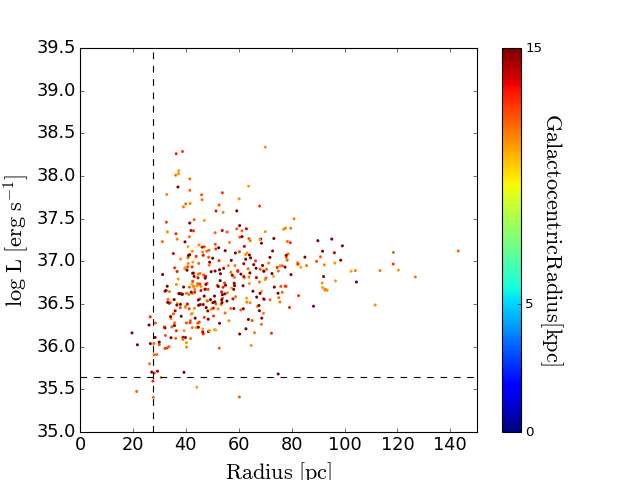

In [85]:
%matplotlib nbagg
k = 11000
j=1
jj=0.6
plt.scatter(sig[(r_reg > k) & (sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], lumi2[(r_reg > k) &(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], marker='.', linewidth=0, s=30, c=r_reg[(r_reg > k) & (sig > 0) & (med2/flux_max2 < j) & (R2 > jj)]/1000, alpha = 1)
cbar=plt.colorbar(ticks=[0,5,15,20.0],pad=0.05)
cbar.set_label('$\mathrm{Galactocentric Radius [kpc]}$', rotation=270, fontsize=20, fontname = 'Helvetica', labelpad=20)
plt.axhline(35.65, color='k', linestyle='--')
plt.axvline(27.5, color='k', linestyle='--')



plt.clim(0,15)
plt.xticks(fontsize=16.0)
plt.yticks(fontsize=16.0)
#plt.plot(r10,q-11.86,c='k', linestyle='dashed', linewidth=3) # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(r100_test3,q-11.86, c='k',linestyle='dashed', linewidth=3)
#plt.plot(r100_test,q-11.86, c='k',linestyle='dashed', linewidth=3)
#plt.plot(r100,q-11.86, c='k',linestyle='dashed', linewidth=3)
#plt.plot(r100_test2,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test4,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10075,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r1000,q-11.86, c='k', linestyle='dashed', linewidth=3) # 10000K, ne = np = 1000 cm-3 for FMI and different mass

#plt.plot(r1000,q-11.86, c='k', linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 1000 cm-3 for FMI and different mass
#plt.plot(r100_test4,q-11.86, c='orange',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.01}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test2,q-11.86, c='yellow',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10075,q-11.86, c='b',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100,q-11.86, c='aqua',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test,q-11.86, c='purple',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test3,q-11.86, c='r',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.00001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 10 cm-3 for FMI and different mass

#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.36,0.95),xycoords='axes fraction',\
#            fontsize=12.0, color='r', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.33),xycoords='axes fraction',\
#            fontsize=12.0, color='g', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.76),xycoords='axes fraction',\
#            fontsize=12.0, color='b', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0001}$',xy=(0.39,0.7),xycoords='axes fraction',\
#            fontsize=12.0, color='purple', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.001}$',xy=(0.38,0.9),xycoords='axes fraction',\
#            fontsize=12.0, color='orange', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.85),xycoords='axes fraction',\
#            fontsize=12.0, color=(0,0,0.4), backgroundcolor = 'w')

plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=20)
plt.xlabel('$\mathrm{Radius\,\,[pc]}$', fontname='Helvetica',fontsize=20)
#leg = plt.legend(loc='upper right',fontsize=10)
leg.get_frame().set_alpha(0.7)
plt.xlim(0,150)
plt.ylim(35,39.5)
plt.show()

<IPython.core.display.Javascript object>


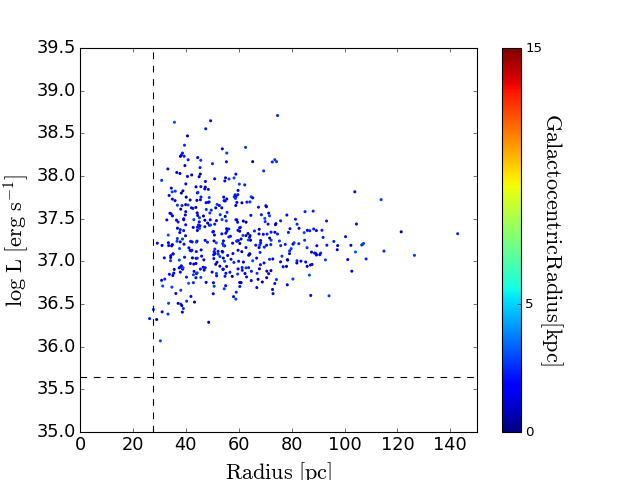

In [84]:
%matplotlib nbagg
k=3000
j=1
jj=0.6
plt.scatter(sig[(r_reg < k) & (sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], lumi2[(r_reg < k) &(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], marker='.', linewidth=0, s=30, c=r_reg[(r_reg < k) & (sig > 0) & (med2/flux_max2 < j) & (R2 > jj)]/1000, alpha = 1)
cbar=plt.colorbar(ticks=[0,5,15,20.0],pad=0.05)
cbar.set_label('$\mathrm{Galactocentric Radius [kpc]}$', rotation=270, fontsize=20, fontname = 'Helvetica', labelpad=20)
plt.axhline(35.65, color='k', linestyle='--')
plt.axvline(27.5, color='k', linestyle='--')



plt.clim(0,15)
plt.xticks(fontsize=16.0)
plt.yticks(fontsize=16.0)
#plt.plot(r10,q-11.86,c='k', linestyle='dashed', linewidth=3) # 10000K, ne = np = 10 cm-3 for FMI and different mass
#plt.plot(r100_test3,q-11.86, c='k',linestyle='dashed', linewidth=3)
#plt.plot(r100_test,q-11.86, c='k',linestyle='dashed', linewidth=3)
#plt.plot(r100,q-11.86, c='k',linestyle='dashed', linewidth=3)
#plt.plot(r100_test2,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test4,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10075,q-11.86, c='k',linestyle='dashed', linewidth=3) # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r1000,q-11.86, c='k', linestyle='dashed', linewidth=3) # 10000K, ne = np = 1000 cm-3 for FMI and different mass

#plt.plot(r1000,q-11.86, c='k', linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 1000 cm-3 for FMI and different mass
#plt.plot(r100_test4,q-11.86, c='orange',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.01}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test2,q-11.86, c='yellow',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10075,q-11.86, c='b',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100,q-11.86, c='aqua',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test,q-11.86, c='purple',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r100_test3,q-11.86, c='r',linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.00001}$') # 10000K, ne = np = 100 cm-3 for FMI and different mass
#plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=1, label='$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}, \epsilon = 0.0005}$') # 10000K, ne = np = 10 cm-3 for FMI and different mass

#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.36,0.95),xycoords='axes fraction',\
#            fontsize=12.0, color='r', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.33),xycoords='axes fraction',\
#            fontsize=12.0, color='g', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.76),xycoords='axes fraction',\
#            fontsize=12.0, color='b', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0001}$',xy=(0.39,0.7),xycoords='axes fraction',\
#            fontsize=12.0, color='purple', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.001}$',xy=(0.38,0.9),xycoords='axes fraction',\
#            fontsize=12.0, color='orange', backgroundcolor = 'w')
#plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}, \epsilon = 0.0005}$',xy=(0.39,0.85),xycoords='axes fraction',\
#            fontsize=12.0, color=(0,0,0.4), backgroundcolor = 'w')

plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=20)
plt.xlabel('$\mathrm{Radius\,\,[pc]}$', fontname='Helvetica',fontsize=20)
#leg = plt.legend(loc='upper right',fontsize=10)
leg.get_frame().set_alpha(0.7)
plt.xlim(0,150)
plt.ylim(35,39.5)
plt.show()

<IPython.core.display.Javascript object>


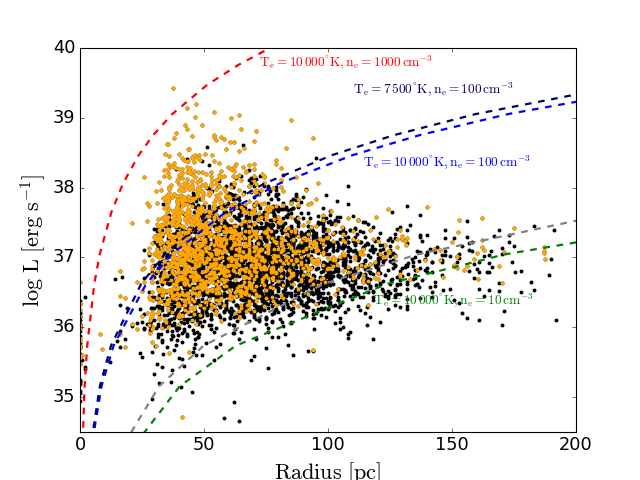

In [140]:
%matplotlib nbagg

j=1
jj=0.05
plt.scatter(sigf[(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], lumi2[(sig > 0) & (med2/flux_max2 < j) & (R2 > jj)], marker='.', c='k', s=50, linewidths = 0.0, alpha = 1)
plt.scatter(sigf[(sig > 0) & (med2/flux_max2 < jj) & (R2 > jj)], lumi2[(sig > 0) & (med2/flux_max2 < jj) & (R2 > jj)], marker='.', s=50, c = 'orange', linewidths = 0.0, alpha = 1)

plt.xticks(fontsize=16.0)
plt.yticks(fontsize=16.0)
plt.plot(r10,q-11.86,c='g', linestyle='dashed', linewidth=2) # 10000K, ne = np = 10 cm-3 for FMI and different mass
plt.plot(r10_test,q-11.86,c='grey', linestyle='dashed', linewidth=2) # 10000K, ne = np = 10 cm-3 for FMI and different mass
plt.plot(r100,q-11.86, c='b',linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r10075,q-11.86, c=(0,0,0.4),linestyle='dashed', linewidth=2) # 10000K, ne = np = 100 cm-3 for FMI and different mass
plt.plot(r1000,q-11.86, c='r', linestyle='dashed', linewidth=2) # 10000K, ne = np = 1000 cm-3 for FMI and different mass

plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 10\,cm^{-3}}$',xy=(0.59,0.33),xycoords='axes fraction',\
            fontsize=12.0, color='g')
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.57,0.69),xycoords='axes fraction',\
            fontsize=12.0, color='b')
plt.annotate('$\mathrm{T_e = 7\,500^\degree K, n_e = 100\,cm^{-3}}$',xy=(0.55,0.88),xycoords='axes fraction',\
            fontsize=12.0, color=(0,0,0.4))
plt.annotate('$\mathrm{T_e = 10\,000^\degree K, n_e = 1000\,cm^{-3}}$',xy=(0.36,0.95),xycoords='axes fraction',\
            fontsize=12.0, color='r')
plt.ylabel('$\mathrm{log\,\,L\,\,[erg\,\,s^{-1}]}$', \
           fontname='Helvetica',fontsize=20)
plt.xlabel('$\mathrm{Radius\,\,[pc]}$', fontname='Helvetica',fontsize=20)
plt.xlim(0,200)
plt.ylim(34.5,40)
plt.show()

In [141]:
print len(np.where(cat == 1)[0])
print len(np.where(cat == 2)[0])
print len(np.where(cat == 3)[0])
print len(np.where(cat == 4)[0])

448
772
1785
1280
